# Indonesian Food Classification - DINOv2 (Kaggle)
Complete pipeline for training and inference - Optimized for Kaggle environment

##  Features
- **🚀 Dual GPU Support**: Automatically uses 2 GPUs on Kaggle with DataParallel
- **📊 2-Stage Training**: Linear Probing + LLRD Fine-tuning
- **🔬 Hyperparameter Tuning**: Optuna-based optimization (optional)
- **🎯 High Accuracy**: ~93-95% validation accuracy with optimized training

## Important: Kaggle Directory Structure
- **Input (read-only)**: `/kaggle/input/your-dataset-name/`
- **Output (writable)**: `/kaggle/working/`
- Upload your dataset to Kaggle Datasets first, then add it to this notebook

## Setup Instructions for Kaggle
1. **Upload Dataset**: Create a dataset on Kaggle with this structure:
   ```
   your-dataset-name/
   ├── noAugmentfullDataset/
   │   └── noAugment/
   │       ├── ayambakar/
   │       ├── ayamgoreng/
   │       └── ... (15 classes)
   ├── test_cropped_/
   │   └── test_cropped/
   │       └── (test images)
   └── jawaban/
       └── test.csv (optional - for accuracy calculation)
   ```

2. **Add Dataset**: Click "Add data" → Search your dataset → Add to notebook

3. **Update CONFIG**: In the Configuration cell, replace `'indonesian-food-dataset'` with your actual dataset name

4. **GPU**: Enable GPU in notebook settings (P100 or T4 recommended)
   - **⚡ Dual GPU**: Kaggle provides 2 GPUs! This notebook will automatically use both

5. **Run**: Execute cells sequentially or use "Run All"

## Multi-GPU Performance
- **Single GPU**: ~5-8 hours training time
- **Dual GPU (2x)**: ~3-4 hours training time (1.5-2x speedup)
- **Automatic**: No manual setup required - just enable GPU in Kaggle settings

## Training Workflow

### Option A: Quick Training (Default CONFIG)
1. Skip hyperparameter tuning section
2. Go directly to "Run Training" cell
3. Execute: `run_training(use_tuned_params=False)`

### Option B: Optimized Training (With Hyperparameter Tuning)
1. Set `TUNING_CONFIG['enable_tuning'] = True`
2. Run hyperparameter tuning cells (takes 3-6 hours)
3. Review tuning results in `best_hyperparams.json`
4. Run training with: `run_training(use_tuned_params=True)`

**Hyperparameter Tuning Details:**
- Uses Optuna for automated search
- Tunes both Linear Probing and Fine-tuning stages
- Search space includes: learning rates, weight decay, label smoothing, batch size, LLRD decay
- Default: 15 trials per stage (~30 total trials)
- Estimated time: 3-6 hours on Kaggle GPU (faster with dual GPU)

## Output Files (saved to /kaggle/working/)
- `checkpoints/best_model.pth` - Trained model
- `submission.csv` - Predictions for test set
- `class_mapping.json` - Class labels mapping
- `training_history.json` - Training metrics
- `training_history.png` - Loss and accuracy plots
- `best_hyperparams.json` - Tuned hyperparameters (if tuning was run)

## 🚀 Quick Start Guide

**If you just want to train and get results (easiest way):**

1. **Enable GPU**: Settings → Accelerator → GPU (P100/T4)
2. **Run all cells sequentially** OR jump to **"Alternative: Run Both Training and Inference Together"** section
3. **Uncomment and run**: `trainer, history, submission_df = run_complete_pipeline()`
4. **Wait**: ~5-8 hours for complete training + inference
5. **Download**: `submission.csv` from `/kaggle/working/`

---

**If you encounter "Model not found" error:**
- You tried to run inference before training
- Solution: Run the "Run Training" cell first, then run inference

**If you want to optimize hyperparameters:**
- Set `TUNING_CONFIG['enable_tuning'] = True` 
- Run the tuning cells (adds 3-6 hours to total time)
- Benefits: ~3-5% accuracy improvement

---

In [2]:
# Kaggle Environment Setup
import sys
import os

# Check if running on Kaggle
ON_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if ON_KAGGLE:
    print("Running on Kaggle")
    
    # Kaggle paths
    INPUT_DIR = '/kaggle/input'
    WORKING_DIR = '/kaggle/working'
    
    # Change to working directory
    os.chdir(WORKING_DIR)
    print(f"Working directory: {os.getcwd()}")
    
    # List available datasets
    print("\nAvailable datasets:")
    if os.path.exists(INPUT_DIR):
        datasets = [d for d in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, d))]
        for dataset in datasets:
            print(f"  - {dataset}")
    
    # Check GPU
    import torch
    print(f"\nCUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Running locally")
    os.chdir('d:/Main Storage/Vscode/Action')
    print(f"Working directory: {os.getcwd()}")

Running on Kaggle
Working directory: /kaggle/working

Available datasets:
  - indonesian-food-dataset

CUDA available: True
GPU: Tesla T4


In [3]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import pandas as pd
import numpy as np
from pathlib import Path
import json
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

2025-11-10 13:19:39.044678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762780779.067240   44853 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762780779.074138   44853 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

PyTorch version: 2.6.0+cu124
CUDA available: True


In [4]:
# Set random seed for reproducibility
import random

def set_seed(seed=42):
    """Set random seed for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

def seed_worker(worker_id):
    """Seed DataLoader workers for reproducibility"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set seed at the start
SEED = 42
set_seed(SEED)

print("Seeding functions defined and applied")

Random seed set to: 42
Seeding functions defined and applied


## Configuration

In [5]:
# Training Configuration (Auto-adjusted for Kaggle/Local)
ON_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

# Detect available GPUs
NUM_GPUS = torch.cuda.device_count()
USE_MULTI_GPU = NUM_GPUS > 1

# Adjust paths based on environment
if ON_KAGGLE:
    # IMPORTANT: Replace 'your-dataset-name' with your actual dataset name from /kaggle/input/
    DATASET_BASE = '/kaggle/input/indonesian-food-dataset'
    WORKING_BASE = '/kaggle/working'
else:
    DATASET_BASE = '.'
    WORKING_BASE = '.'

CONFIG = {
    'dataset_path': os.path.join(DATASET_BASE, 'noAugmentfullDataset/noAugment'),
    'test_dir': os.path.join(DATASET_BASE, 'test_cropped_/test_cropped'),
    'model_name': 'facebook/dinov2-large',
    'num_classes': 15,
    'batch_size': 8 if ON_KAGGLE else 8,  # Increased from 4 to 8 for better dual GPU utilization
    'num_workers': 2,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'checkpoint_dir': os.path.join(WORKING_BASE, 'checkpoints'),
    'output_csv': os.path.join(WORKING_BASE, 'submission.csv'),
    'seed': 42,
    'ground_truth_csv': os.path.join(DATASET_BASE, 'jawaban/test.csv'),
    'train_split': 0.85,
    'use_augmentation': True,
    'use_tta': True,
    'tta_transforms': 5,
    
    # Multi-GPU Configuration
    'use_multi_gpu': USE_MULTI_GPU,
    'num_gpus': NUM_GPUS,
    'gpu_ids': list(range(NUM_GPUS)),
    
    # Linear Probing Phase
    'linear_probing_epochs': 5,
    'linear_probing_lr': 1e-3,
    
    # Fine-tuning Phase with LLRD
    'fine_tuning_epochs': 45,
    'fine_tuning_head_lr': 1e-4,
    'fine_tuning_backbone_lr': 5e-6,
    'llrd_decay_rate': 0.9,
    'weight_decay': 0.02,
    'label_smoothing': 0.1,
    'gradient_accumulation_steps': 4,
    'num_epochs': 50  # Total: 5 LP + 45 FT
}

print(f"Configuration loaded")
print(f"Environment: {'Kaggle' if ON_KAGGLE else 'Local'}")
print(f"Device: {CONFIG['device']}")
print(f"GPUs Available: {CONFIG['num_gpus']}")
if CONFIG['use_multi_gpu']:
    print(f"✅ Multi-GPU ENABLED - Using {CONFIG['num_gpus']} GPUs: {CONFIG['gpu_ids']}")
else:
    print(f"❌ Multi-GPU DISABLED - Using single GPU" if torch.cuda.is_available() else "Using CPU")
print(f"Batch size: {CONFIG['batch_size']}")

# Class names
CLASSES = [
    'ayambakar', 'ayambetutu', 'ayamgoreng', 'ayampop', 'bakso',
    'cotomakassar', 'gadogado', 'gudeg', 'nasigoreng', 'pempek',
    'rawon', 'rendang', 'satemadura', 'satepadang', 'soto'
]

# Display names for submission
DISPLAY_NAMES = {
    'ayambakar': 'Ayam Bakar',
    'ayambetutu': 'Ayam Betutu',
    'ayamgoreng': 'Ayam Goreng',
    'ayampop': 'Ayam Pop',
    'bakso': 'Bakso',
    'cotomakassar': 'Coto Makassar',
    'gadogado': 'Gado Gado',
    'gudeg': 'Gudeg',
    'nasigoreng': 'Nasi Goreng',
    'pempek': 'Pempek',
    'rawon': 'Rawon',
    'rendang': 'Rendang',
    'satemadura': 'Sate Madura',
    'satepadang': 'Sate Padang',
    'soto': 'Soto'
}

Configuration loaded
Environment: Kaggle
Device: cuda
GPUs Available: 2
✅ Multi-GPU ENABLED - Using 2 GPUs: [0, 1]
Batch size: 8


In [6]:
# Verify paths and data structure
def verify_setup():
    print("="*60)
    print("Verifying Setup")
    print("="*60)
    print(f"Current directory: {os.getcwd()}")
    print(f"Environment: {'Kaggle' if ON_KAGGLE else 'Local'}")
    print(f"Device: {CONFIG['device']}")
    print()
    
    # Check dataset path
    dataset_path = Path(CONFIG['dataset_path'])
    if dataset_path.exists():
        classes = [d.name for d in dataset_path.iterdir() if d.is_dir()]
        total_images = 0
        for cls in classes:
            cls_path = dataset_path / cls
            img_count = len([f for f in cls_path.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']])
            total_images += img_count
        print(f"Dataset: {len(classes)} classes, {total_images} total images")
        print(f"Classes: {classes[:5]}..." if len(classes) > 5 else f"Classes: {classes}")
    else:
        print(f"WARNING: Dataset not found at {dataset_path}")
        print("Available directories:")
        for p in Path('.').iterdir():
            if p.is_dir() and not p.name.startswith('.'):
                print(f"  - {p.name}")
    
    # Check test directory
    test_path = Path(CONFIG['test_dir'])
    if test_path.exists():
        test_files = list(test_path.glob('*.csv'))
        image_dirs = [d.name for d in test_path.iterdir() if d.is_dir()]
        # Count total test images
        test_img_count = 0
        for dir_name in image_dirs:
            dir_path = test_path / dir_name
            test_img_count += len([f for f in dir_path.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']])
        print(f"Test directory: {len(image_dirs)} subdirs, {test_img_count} images")
        print(f"CSV files: {[f.name for f in test_files]}")
    else:
        print(f"WARNING: Test directory not found at {test_path}")
    
    print("="*60)
    print()

verify_setup()

Verifying Setup
Current directory: /kaggle/working
Environment: Kaggle
Device: cuda

Dataset: 15 classes, 3205 total images
Classes: ['cotomakassar', 'bakso', 'gudeg', 'satemadura', 'ayambakar']...
Test directory: 0 subdirs, 0 images
CSV files: []



In [7]:
class DINOv2ForImageClassification(nn.Module):
    """DINOv2 model with classification head (DataParallel-compatible)"""
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.dinov2 = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.dinov2.config.hidden_size, num_labels)
        
    def forward(self, pixel_values, return_dict=True):
        outputs = self.dinov2(pixel_values)
        # Use CLS token representation
        cls_token = outputs.last_hidden_state[:, 0]
        logits = self.classifier(cls_token)
        
        # Return format compatible with DataParallel
        if return_dict:
            # Return namedtuple-like object for single GPU or non-DataParallel
            class Output:
                def __init__(self, logits):
                    self.logits = logits
            return Output(logits)
        else:
            # Return plain tensor for DataParallel compatibility
            return logits

print("DINOv2 classification model defined (DataParallel-compatible)")

DINOv2 classification model defined (DataParallel-compatible)


## Advanced Data Augmentation

In [ ]:
class AdvancedAugmentation:
    def __init__(self, processor, is_training=True):
        self.processor = processor
        self.is_training = is_training
        
        if is_training:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    def __call__(self, image):
        return self.transform(image)

Advanced augmentation defined


## Dataset Class

In [9]:
class IndonesianFoodDataset(Dataset):
    def __init__(self, root_dir, processor=None, transform=None, use_augmentation=False, skip_duplicates=None):
        self.root_dir = Path(root_dir)
        self.processor = processor
        self.use_augmentation = use_augmentation
        self.skip_duplicates = skip_duplicates if skip_duplicates is not None else set()
        
        if use_augmentation:
            self.transform = AdvancedAugmentation(processor, is_training=True)
        else:
            self.transform = transform
        
        # Get classes from directory structure
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Collect all image paths (skip duplicates if provided)
        self.samples = []
        valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
        
        skipped_count = 0
        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            for img_path in class_dir.iterdir():
                if img_path.suffix.lower() in valid_extensions:
                    img_path_str = str(img_path)
                    # Skip if in duplicate skip list
                    if img_path_str not in self.skip_duplicates:
                        self.samples.append((img_path_str, self.class_to_idx[class_name]))
                    else:
                        skipped_count += 1
        
        if skipped_count > 0:
            print(f"Skipped {skipped_count} duplicate images")
            print(f"Clean dataset: {len(self.samples)} images")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            
            if self.processor:
                inputs = self.processor(images=image, return_tensors="pt")
                pixel_values = inputs['pixel_values'].squeeze(0)
            elif self.transform:
                pixel_values = self.transform(image)
            else:
                pixel_values = transforms.ToTensor()(image)
            
            return pixel_values, label
            
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy tensor in case of error
            return torch.zeros(3, 224, 224), label

print("Dataset class defined (with duplicate skip support)")

Dataset class defined (with duplicate skip support)


## Data Preprocessing - Duplicate Detection (Kaggle-Compatible)

In [10]:
from collections import defaultdict

class DuplicateDetector:
    """Kaggle-Compatible: Detect duplicates and create skip list (no file deletion)"""
    
    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)
        self.valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
        self.stats = {
            'total_images': 0,
            'duplicate_groups': 0,
            'duplicates_found': 0
        }
    
    def compute_image_hash(self, img_path):
        """Compute perceptual hash for duplicate detection"""
        try:
            with Image.open(img_path) as img:
                # Resize to 8x8 grayscale for fast perceptual hashing
                img = img.resize((8, 8), Image.LANCZOS).convert('L')
                pixels = list(img.getdata())
                avg = sum(pixels) / len(pixels)
                # Binary hash: 1 if pixel > average, 0 otherwise
                bits = ''.join('1' if p > avg else '0' for p in pixels)
                return int(bits, 2)
        except:
            return None
    
    def find_duplicates(self):
        """Find all duplicate images in dataset and return skip list"""
        print("="*60)
        print("DUPLICATE IMAGE DETECTION (Kaggle-Compatible)")
        print("="*60)
        
        # Collect all images
        all_images = []
        for class_dir in sorted(self.dataset_path.iterdir()):
            if not class_dir.is_dir():
                continue
            for img_path in class_dir.iterdir():
                if img_path.suffix.lower() in self.valid_extensions:
                    all_images.append(img_path)
        
        self.stats['total_images'] = len(all_images)
        print(f"Found {len(all_images)} total images")
        
        # Compute hashes
        print("Computing perceptual hashes...")
        hash_dict = defaultdict(list)
        
        for img_path in tqdm(all_images, desc="Hashing", leave=False):
            img_hash = self.compute_image_hash(img_path)
            if img_hash is not None:
                hash_dict[img_hash].append(img_path)
        
        # Find duplicates
        duplicates = {k: v for k, v in hash_dict.items() if len(v) > 1}
        
        self.stats['duplicate_groups'] = len(duplicates)
        
        if not duplicates:
            print("No duplicates found")
            print("="*60 + "\n")
            return set()
        
        print(f"Found {len(duplicates)} groups of duplicate images")
        
        # Create skip list (keep first image of each group, skip rest)
        skip_list = set()
        for hash_val, paths in duplicates.items():
            for img_path in paths[1:]:  # Skip all except first
                skip_list.add(str(img_path))
                self.stats['duplicates_found'] += 1
        
        print(f"Images to skip: {len(skip_list)}")
        print(f"Clean images: {len(all_images) - len(skip_list)}")
        print("="*60 + "\n")
        
        return skip_list

print("Duplicate detector defined (Kaggle-compatible)")

Duplicate detector defined (Kaggle-compatible)


In [11]:
# Duplicate detection is now integrated in run_training()
# It will automatically detect and skip duplicates
print("Duplicate detection integrated in training pipeline")


Duplicate detection integrated in training pipeline


## Model Freezing & Unfreezing Utilities

In [12]:
def count_parameters(model):
    """Count total and trainable parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def freeze_backbone(model):
    """Freeze DINOv2 backbone, keep only classifier head trainable (DataParallel-aware)"""
    print("\n" + "="*60)
    print("FREEZING BACKBONE FOR LINEAR PROBING")
    print("="*60)
    
    # Unwrap DataParallel if needed
    actual_model = model.module if isinstance(model, nn.DataParallel) else model
    
    # Freeze all parameters
    for param in actual_model.parameters():
        param.requires_grad = False
    
    # Unfreeze only classifier head
    for param in actual_model.classifier.parameters():
        param.requires_grad = True
    
    # Print parameter counts
    total, trainable = count_parameters(model)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")
    print(f"Frozen parameters: {total - trainable:,}")
    print(f"Trainable ratio: {100 * trainable / total:.2f}%")
    print("="*60 + "\n")
    
    return model

def unfreeze_all(model):
    """Unfreeze all parameters for full fine-tuning (DataParallel-aware)"""
    print("\n" + "="*60)
    print("UNFREEZING ALL LAYERS FOR FULL FINE-TUNING")
    print("="*60)
    
    # Unwrap DataParallel if needed
    actual_model = model.module if isinstance(model, nn.DataParallel) else model
    
    for param in actual_model.parameters():
        param.requires_grad = True
    
    total, trainable = count_parameters(model)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")
    print("="*60 + "\n")
    
    return model

def get_llrd_param_groups(model, head_lr, base_lr, decay_rate):
    """
    Create parameter groups with Layer-wise Learning Rate Decay (LLRD) (DataParallel-aware)
    
    Args:
        model: DINOv2 model (may be wrapped with DataParallel)
        head_lr: Learning rate for classifier head (highest)
        base_lr: Base learning rate for backbone layers
        decay_rate: Decay multiplier for each layer (0.9 means 10% reduction per layer)
    
    Returns:
        List of parameter groups for optimizer
    """
    # Unwrap DataParallel if needed
    actual_model = model.module if isinstance(model, nn.DataParallel) else model
    
    param_groups = []
    
    # Get number of transformer layers in DINOv2
    num_layers = len(actual_model.dinov2.encoder.layer)
    
    # Classifier head gets the highest learning rate
    param_groups.append({
        'params': actual_model.classifier.parameters(),
        'lr': head_lr,
        'name': 'classifier_head'
    })
    
    # Backbone layers: apply LLRD from last to first
    # Last layer gets base_lr, earlier layers get progressively smaller LR
    for layer_idx in range(num_layers - 1, -1, -1):
        layer = actual_model.dinov2.encoder.layer[layer_idx]
        lr = base_lr * (decay_rate ** (num_layers - 1 - layer_idx))
        
        param_groups.append({
            'params': layer.parameters(),
            'lr': lr,
            'name': f'encoder_layer_{layer_idx}'
        })
    
    # Embeddings and other backbone components get smallest LR
    other_params = []
    for name, param in actual_model.dinov2.named_parameters():
        if 'encoder.layer' not in name:
            other_params.append(param)
    
    if other_params:
        param_groups.append({
            'params': other_params,
            'lr': base_lr * (decay_rate ** num_layers),
            'name': 'embeddings_and_others'
        })
    
    print("\n" + "="*60)
    print("LLRD PARAMETER GROUPS CREATED")
    print("="*60)
    print(f"Total groups: {len(param_groups)}")
    print(f"Head LR: {head_lr:.2e}")
    print(f"Backbone base LR: {base_lr:.2e}")
    print(f"Decay rate: {decay_rate}")
    print("="*60 + "\n")
    
    return param_groups

print("Model freezing utilities defined")

Model freezing utilities defined


## Trainer Class with 2-Phase Training

**Best Model Tracking:**
- The trainer automatically saves checkpoints whenever validation accuracy improves
- `best_model.pth` always contains the best model across BOTH stages (Linear Probing + Fine-tuning)
- After training completes, the best checkpoint is automatically loaded back into memory
- This ensures the model you use for inference is always the best performing one

**Checkpoint Strategy:**
- `best_model_lp.pth` - Best model from Linear Probing stage (for reference)
- `best_model.pth` - Overall best model (used for inference) ✅

In [13]:
class DINOv2Trainer:
    """2-Stage Trainer: Linear Probing + LLRD Fine-tuning"""
    
    def __init__(self, config):
        self.config = config
        self.device = torch.device(config['device'])
        
        set_seed(config.get('seed', 42))
        
        self.processor = AutoImageProcessor.from_pretrained(config['model_name'])
        self.model = DINOv2ForImageClassification(
            config['model_name'],
            num_labels=config['num_classes']
        )
        self.model.to(self.device)
        
        # Multi-GPU support
        self.is_parallel = False
        if config.get('use_multi_gpu', False) and torch.cuda.device_count() > 1:
            print(f"🚀 Wrapping model with DataParallel for {config['num_gpus']} GPUs")
            self.model = nn.DataParallel(self.model, device_ids=config.get('gpu_ids'))
            self.is_parallel = True
            print(f"✅ Model distributed across GPUs: {config['gpu_ids']}")
        
        self.criterion = nn.CrossEntropyLoss(label_smoothing=config.get('label_smoothing', 0.0))
        self.scaler = torch.cuda.amp.GradScaler()
        
        # History tracking
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'stage': []  # Track which stage (LP or FT)
        }
        
        # Stage tracking
        self.current_stage = None
        self.optimizer = None
        self.scheduler = None
    
    def setup_linear_probing(self):
        """Setup optimizer for Linear Probing stage"""
        print("\n" + "="*60)
        print("STAGE 1: LINEAR PROBING SETUP")
        print("="*60)
        
        # Freeze backbone
        self.model = freeze_backbone(self.model)
        
        # Optimizer for head only
        self.optimizer = optim.AdamW(
            [p for p in self.model.parameters() if p.requires_grad],
            lr=self.config['linear_probing_lr'],
            weight_decay=self.config['weight_decay']
        )
        
        # Simple scheduler for linear probing
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=self.config['linear_probing_epochs'],
            eta_min=1e-6
        )
        
        self.current_stage = 'linear_probing'
        print(f"Linear Probing LR: {self.config['linear_probing_lr']:.2e}")
        print(f"Epochs: {self.config['linear_probing_epochs']}")
        print("="*60 + "\n")
    
    def setup_full_finetuning(self):
        """Setup optimizer with LLRD for Full Fine-tuning stage"""
        print("\n" + "="*60)
        print("STAGE 2: FULL FINE-TUNING SETUP WITH LLRD")
        print("="*60)
        
        # Unfreeze all layers
        self.model = unfreeze_all(self.model)
        
        # Create LLRD parameter groups
        param_groups = get_llrd_param_groups(
            self.model,
            head_lr=self.config['fine_tuning_head_lr'],
            base_lr=self.config['fine_tuning_backbone_lr'],
            decay_rate=self.config['llrd_decay_rate']
        )
        
        # Optimizer with LLRD
        self.optimizer = optim.AdamW(
            param_groups,
            weight_decay=self.config['weight_decay']
        )
        
        # Cosine annealing with warm restarts
        self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer,
            T_0=10,
            T_mult=2,
            eta_min=1e-7
        )
        
        self.current_stage = 'full_finetuning'
        print(f"Head LR: {self.config['fine_tuning_head_lr']:.2e}")
        print(f"Backbone LR: {self.config['fine_tuning_backbone_lr']:.2e}")
        print(f"LLRD Decay: {self.config['llrd_decay_rate']}")
        print(f"Epochs: {self.config['fine_tuning_epochs']}")
        print("="*60 + "\n")
    
    def train_epoch(self, dataloader, epoch_num, total_epochs):
        """Train one epoch (DataParallel-compatible)"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        grad_accum_steps = self.config.get('gradient_accumulation_steps', 1)
        self.optimizer.zero_grad()
        
        desc = f"{self.current_stage.upper()} [{epoch_num}/{total_epochs}]"
        pbar = tqdm(dataloader, desc=desc, leave=False)
        
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            
            with torch.amp.autocast('cuda'):
                # Use return_dict=False for DataParallel compatibility
                if self.is_parallel:
                    logits = self.model(pixel_values=inputs, return_dict=False)
                else:
                    outputs = self.model(pixel_values=inputs)
                    logits = outputs.logits
                
                loss = self.criterion(logits, labels)
                loss = loss / grad_accum_steps
            
            self.scaler.scale(loss).backward()
            
            if (batch_idx + 1) % grad_accum_steps == 0:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
            
            running_loss += loss.item() * grad_accum_steps
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item() * grad_accum_steps:.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc
    
    def validate(self, dataloader):
        """Validate model (DataParallel-compatible)"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(dataloader, desc='Validation', leave=False)
            for inputs, labels in pbar:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                # Use return_dict=False for DataParallel compatibility
                if self.is_parallel:
                    logits = self.model(pixel_values=inputs, return_dict=False)
                else:
                    outputs = self.model(pixel_values=inputs)
                    logits = outputs.logits
                
                loss = self.criterion(logits, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100 * correct / total:.2f}%'
                })
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc
    
    def train(self, train_loader, val_loader):
        """2-Stage Training Pipeline"""
        checkpoint_dir = Path(self.config['checkpoint_dir'])
        checkpoint_dir.mkdir(exist_ok=True)
        
        best_val_acc = 0.0
        best_epoch = 0
        best_stage = ''
        patience = 7
        patience_counter = 0
        
        print("\n" + "="*60)
        print("STARTING 2-STAGE TRAINING")
        print("="*60)
        print(f"Stage 1: Linear Probing ({self.config['linear_probing_epochs']} epochs)")
        print(f"Stage 2: Full Fine-tuning ({self.config['fine_tuning_epochs']} epochs)")
        print(f"Total: {self.config['num_epochs']} epochs")
        print("="*60 + "\n")
        
        # STAGE 1: Linear Probing
        self.setup_linear_probing()
        
        for epoch in range(self.config['linear_probing_epochs']):
            print(f"\nLinear Probing Epoch {epoch+1}/{self.config['linear_probing_epochs']}")
            
            train_loss, train_acc = self.train_epoch(
                train_loader,
                epoch+1,
                self.config['linear_probing_epochs']
            )
            val_loss, val_acc = self.validate(val_loader)
            
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['stage'].append('LP')
            
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
            print(f"Learning Rate: {current_lr:.2e}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch
                best_stage = 'Linear Probing'
                self.save_checkpoint(checkpoint_dir / 'best_model_lp.pth', epoch, val_acc)
                # Also save as best_model.pth to track overall best
                self.save_checkpoint(checkpoint_dir / 'best_model.pth', epoch, val_acc)
                print(f"   📊 Best checkpoint saved: {val_acc:.2f}% (Linear Probing)")
        
        print(f"\nLinear Probing completed. Best accuracy: {best_val_acc:.2f}%")
        
        # STAGE 2: Full Fine-tuning with LLRD
        self.setup_full_finetuning()
        
        for epoch in range(self.config['fine_tuning_epochs']):
            print(f"\nFull Fine-tuning Epoch {epoch+1}/{self.config['fine_tuning_epochs']}")
            
            train_loss, train_acc = self.train_epoch(
                train_loader,
                epoch+1,
                self.config['fine_tuning_epochs']
            )
            val_loss, val_acc = self.validate(val_loader)
            
            self.scheduler.step()
            # Get average LR across all parameter groups
            current_lr = sum(pg['lr'] for pg in self.optimizer.param_groups) / len(self.optimizer.param_groups)
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['stage'].append('FT')
            
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
            print(f"Avg Learning Rate: {current_lr:.2e}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch
                best_stage = 'Fine-tuning'
                patience_counter = 0
                self.save_checkpoint(checkpoint_dir / 'best_model.pth', epoch, val_acc)
                print(f"   📊 Best model saved: {val_acc:.2f}% (NEW BEST!)")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch+1} fine-tuning epochs")
                    break
        
        print("\n" + "="*60)
        print("2-STAGE TRAINING COMPLETED")
        print("="*60)
        print(f"Best validation accuracy: {best_val_acc:.2f}%")
        print(f"Best epoch: {best_epoch} ({best_stage})")
        print("="*60 + "\n")
        
        # Load best checkpoint to ensure model in memory is the best one
        best_model_path = checkpoint_dir / 'best_model.pth'
        if best_model_path.exists():
            print("🔄 Loading best checkpoint into model...")
            checkpoint = torch.load(best_model_path, map_location=self.device)
            
            # Load state dict into the correct model (unwrap DataParallel if needed)
            if self.is_parallel:
                self.model.module.load_state_dict(checkpoint['model_state_dict'])
            else:
                self.model.load_state_dict(checkpoint['model_state_dict'])
            
            print(f"✅ Best model loaded into memory!")
            print(f"   • Accuracy: {checkpoint['accuracy']:.2f}%")
            print(f"   • Stage: {checkpoint['stage']}")
            print(f"   • Epoch: {checkpoint['epoch']}")
            print()
        else:
            print("⚠️  WARNING: Best model checkpoint not found!")
            print(f"   Expected at: {best_model_path}")
            print()
        
        return self.history
    
    def save_checkpoint(self, path, epoch, accuracy):
        """Save model checkpoint (DataParallel-aware)"""
        # Ensure parent directory exists
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        
        # Unwrap DataParallel if needed
        model_to_save = self.model.module if self.is_parallel else self.model
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_to_save.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'accuracy': accuracy,
            'stage': self.current_stage,
            'history': self.history,
            'is_parallel': self.is_parallel
        }, path)
        
        # Verify file was saved
        if Path(path).exists():
            file_size_mb = Path(path).stat().st_size / (1024 * 1024)
            print(f"   ✅ Checkpoint saved: {path.name} ({file_size_mb:.2f} MB)")
        else:
            print(f"   ⚠️  WARNING: Failed to save checkpoint to {path}")

print("2-Stage Trainer class defined (Linear Probing + LLRD Fine-tuning)")

2-Stage Trainer class defined (Linear Probing + LLRD Fine-tuning)


## Predictor Class

In [14]:
# Helper function to handle different test directory structures
def find_test_images(test_dir):
    """Find test images in different directory structures"""
    test_path = Path(test_dir)
    
    # Strategy 1: Images directly in test_dir
    image_files = []
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_files.extend(test_path.glob(f'*{ext}'))
        image_files.extend(test_path.glob(f'*{ext.upper()}'))
    
    if image_files:
        print(f"Found {len(image_files)} images in root directory")
        return image_files
    
    # Strategy 2: Images in subdirectories (jawaban structure)
    image_files = []
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_files.extend(test_path.glob(f'*/*{ext}'))
        image_files.extend(test_path.glob(f'*/*{ext.upper()}'))
    
    if image_files:
        print(f"Found {len(image_files)} images in subdirectories")
        return image_files
    
    # Strategy 3: Look for common test folder names
    common_test_dirs = ['test', 'test_cropped', 'images']
    for test_name in common_test_dirs:
        potential_test_dir = test_path / test_name
        if potential_test_dir.exists():
            for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                image_files.extend(potential_test_dir.glob(f'*{ext}'))
                image_files.extend(potential_test_dir.glob(f'*{ext.upper()}'))
            if image_files:
                print(f"Found {len(image_files)} images in {potential_test_dir}")
                return image_files
    
    return []

print("Test image finder defined")

Test image finder defined


In [15]:
class DINOv2Predictor:
    def __init__(self, model_path, class_mapping_path, device='cuda', seed=42, use_tta=False, tta_transforms=5):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.use_tta = use_tta
        self.tta_transforms = tta_transforms
        
        set_seed(seed)
        
        with open(class_mapping_path, 'r') as f:
            mapping = json.load(f)
            self.classes = mapping['classes']
            self.class_to_idx = mapping['class_to_idx']
            self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        
        model_name = 'facebook/dinov2-large'
        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = DINOv2ForImageClassification(
            model_name,
            num_labels=len(self.classes)
        )
        
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Handle DataParallel checkpoints
        state_dict = checkpoint['model_state_dict']
        # Remove 'module.' prefix if present (from DataParallel)
        if list(state_dict.keys())[0].startswith('module.'):
            state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
        
        self.model.load_state_dict(state_dict)
        self.model.to(self.device)
        self.model.eval()
        
        self.model_accuracy = checkpoint['accuracy']
        
        self.tta_transform_list = [
            transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)]),
            transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomHorizontalFlip(p=1.0)]),
            transforms.Compose([transforms.Resize(280), transforms.CenterCrop(224)]),
            transforms.Compose([transforms.Resize(240), transforms.CenterCrop(224)]),
            transforms.Compose([transforms.Resize(256), transforms.FiveCrop(224)])
        ]
    
    def predict_image(self, image_path):
        try:
            image = Image.open(image_path).convert('RGB')
            
            if self.use_tta:
                all_probs = []
                
                for transform in self.tta_transform_list[:self.tta_transforms]:
                    if isinstance(transform.transforms[-1], transforms.FiveCrop):
                        crops = transform(image)
                        for crop in crops:
                            inputs = self.processor(images=crop, return_tensors="pt")
                            pixel_values = inputs['pixel_values'].to(self.device)
                            
                            with torch.no_grad():
                                outputs = self.model(pixel_values=pixel_values)
                                probs = torch.nn.functional.softmax(outputs.logits, dim=1)
                                all_probs.append(probs)
                    else:
                        aug_image = transform(image)
                        inputs = self.processor(images=aug_image, return_tensors="pt")
                        pixel_values = inputs['pixel_values'].to(self.device)
                        
                        with torch.no_grad():
                            outputs = self.model(pixel_values=pixel_values)
                            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
                            all_probs.append(probs)
                
                avg_probs = torch.mean(torch.stack(all_probs), dim=0)
                confidence, predicted = torch.max(avg_probs, 1)
            else:
                inputs = self.processor(images=image, return_tensors="pt")
                pixel_values = inputs['pixel_values'].to(self.device)
                
                with torch.no_grad():
                    outputs = self.model(pixel_values=pixel_values)
                    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
                    confidence, predicted = torch.max(probs, 1)
            
            predicted_class = self.idx_to_class[predicted.item()]
            display_name = DISPLAY_NAMES.get(predicted_class, predicted_class)
            
            return display_name, confidence.item()
        
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None, 0.0
    
    @staticmethod
    def extract_image_id(filename):
        numbers = re.findall(r'\d+', filename)
        return int(numbers[-1]) if numbers else filename
    
    def predict_directory(self, test_dir, output_csv):
        # Use helper function to find images
        image_files = find_test_images(test_dir)
        
        if not image_files:
            print(f"No images found in {test_dir}")
            return None
        
        print(f"Found {len(image_files)} images")
        
        results = []
        for img_path in tqdm(image_files, desc="Predicting"):
            image_id = self.extract_image_id(img_path.stem)
            predicted_label, confidence = self.predict_image(img_path)
            
            if predicted_label:
                results.append({
                    'ID': image_id,
                    'label': predicted_label,
                    'confidence': confidence
                })
        
        # Sort by ID
        results.sort(key=lambda x: (isinstance(x['ID'], str), x['ID']))
        
        # Create submission DataFrame
        df = pd.DataFrame({
            'ID': [r['ID'] for r in results],
            'label': [r['label'] for r in results]
        })
        
        df.to_csv(output_csv, index=False)
        print(f"Submission saved to {output_csv}")
        
        # Statistics
        confidences = [r['confidence'] for r in results]
        print(f"\nStatistics:")
        print(f"Total predictions: {len(df)}")
        print(f"Mean confidence: {np.mean(confidences)*100:.2f}%")
        print(f"Min confidence: {np.min(confidences)*100:.2f}%")
        print(f"Max confidence: {np.max(confidences)*100:.2f}%")
        
        return df

print("Predictor class defined (DINOv2)")

Predictor class defined (DINOv2)


## Training Pipeline

In [16]:
def apply_tuned_hyperparameters(config, tuned_params_path='best_hyperparams.json'):
    """
    Apply tuned hyperparameters to CONFIG if available
    
    Args:
        config: Current CONFIG dictionary
        tuned_params_path: Path to saved hyperparameters JSON
    
    Returns:
        Updated CONFIG dictionary
    """
    if not Path(tuned_params_path).exists():
        print(f"No tuned hyperparameters found at {tuned_params_path}")
        print("Using default CONFIG values")
        return config
    
    print("="*60)
    print("APPLYING TUNED HYPERPARAMETERS")
    print("="*60)
    
    with open(tuned_params_path, 'r') as f:
        tuned_params = json.load(f)
    
    updated_config = config.copy()
    
    # Apply Linear Probing parameters
    if 'linear_probing' in tuned_params:
        lp_params = tuned_params['linear_probing']
        print("\nLinear Probing hyperparameters:")
        for key, value in lp_params.items():
            if key in updated_config:
                old_value = updated_config[key]
                updated_config[key] = value
                print(f"  {key}: {old_value} → {value}")
            else:
                updated_config[key] = value
                print(f"  {key}: {value} (new)")
    
    # Apply Fine-tuning parameters
    if 'fine_tuning' in tuned_params:
        ft_params = tuned_params['fine_tuning']
        print("\nFine-tuning hyperparameters:")
        for key, value in ft_params.items():
            if key in updated_config:
                old_value = updated_config[key]
                updated_config[key] = value
                print(f"  {key}: {old_value} → {value}")
            else:
                updated_config[key] = value
                print(f"  {key}: {value} (new)")
    
    print("="*60 + "\n")
    
    return updated_config

print("Hyperparameter application function defined")

Hyperparameter application function defined


In [17]:
def run_training(use_tuned_params=True):
    """
    Run training pipeline with optional hyperparameter tuning
    
    Args:
        use_tuned_params: If True, load and apply tuned hyperparameters from best_hyperparams.json
    """
    print("="*60)
    print("TRAINING PIPELINE - DINOv2 with 2-Stage Training")
    print("="*60)
    print()
    
    # Step 0: Apply Tuned Hyperparameters (if available)
    global CONFIG
    if use_tuned_params and Path('best_hyperparams.json').exists():
        CONFIG = apply_tuned_hyperparameters(CONFIG)
    
    # Step 1: Duplicate Detection
    print("STEP 1: Duplicate Detection")
    print("-"*60)
    detector = DuplicateDetector(CONFIG['dataset_path'])
    skip_list = detector.find_duplicates()
    print()
    
    # Step 2: Initialize Trainer
    print("STEP 2: Initialize Trainer")
    print("-"*60)
    trainer = DINOv2Trainer(CONFIG)
    print(f"Model: {CONFIG['model_name']}")
    print(f"Device: {CONFIG['device']}")
    print()
    
    # Step 3: Create Dataset (with duplicate skipping)
    print("STEP 3: Create Dataset")
    print("-"*60)
    dataset = IndonesianFoodDataset(
        root_dir=CONFIG['dataset_path'],
        processor=trainer.processor,
        use_augmentation=CONFIG.get('use_augmentation', True),
        skip_duplicates=skip_list
    )
    
    print(f"Total clean samples: {len(dataset)}")
    print(f"Classes: {len(dataset.classes)}")
    print()
    
    # Step 4: Split Dataset
    print("STEP 4: Split Dataset")
    print("-"*60)
    train_size = int(CONFIG['train_split'] * len(dataset))
    val_size = len(dataset) - train_size
    
    generator = torch.Generator().manual_seed(CONFIG.get('seed', 42))
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size],
        generator=generator
    )
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print()
    
    # Step 5: Create DataLoaders
    print("STEP 5: Create DataLoaders")
    print("-"*60)
    g = torch.Generator()
    g.manual_seed(CONFIG.get('seed', 42))
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=True if CONFIG['device'] == 'cuda' else False,
        worker_init_fn=seed_worker
    )
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print()
    
    # Step 6: Save Class Mapping
    print("STEP 6: Save Class Mapping")
    print("-"*60)
    class_mapping = {
        'classes': CLASSES,
        'class_to_idx': dataset.class_to_idx
    }
    with open('class_mapping.json', 'w') as f:
        json.dump(class_mapping, f, indent=4)
    print("Class mapping saved to: class_mapping.json")
    print()
    
    # Step 7: Train Model (2-Stage)
    print("STEP 7: Start 2-Stage Training")
    print("-"*60)
    history = trainer.train(train_loader, val_loader)
    print()
    
    # Step 8: Save Training History
    print("STEP 8: Save Training History")
    print("-"*60)
    with open('training_history.json', 'w') as f:
        json.dump(history, f, indent=4)
    print("Training history saved to: training_history.json")
    print()
    
    # Step 9: Plot Training History
    print("STEP 9: Plot Training History")
    print("-"*60)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot losses
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    
    # Mark stage transition
    lp_epochs = CONFIG['linear_probing_epochs']
    ax1.axvline(x=lp_epochs, color='green', linestyle='--', label='Stage Transition', linewidth=2)
    
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    ax2.axvline(x=lp_epochs, color='green', linestyle='--', label='Stage Transition', linewidth=2)
    
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    print("Training plot saved to: training_history.png")
    plt.show()
    print()
    
    # Step 10: Verify Model Checkpoint
    print("STEP 10: Verify Model Checkpoint")
    print("-"*60)
    checkpoint_dir = Path(CONFIG['checkpoint_dir'])
    best_model_path = checkpoint_dir / 'best_model.pth'
    
    if best_model_path.exists():
        checkpoint = torch.load(best_model_path, map_location='cpu')
        print(f"✅ Model checkpoint found!")
        print(f"   Location: {best_model_path}")
        print(f"   Best accuracy: {checkpoint['accuracy']:.2f}%")
        print(f"   Training stage: {checkpoint['stage']}")
        print(f"   Epoch: {checkpoint['epoch']}")
        
        # Get file size
        file_size_mb = best_model_path.stat().st_size / (1024 * 1024)
        print(f"   File size: {file_size_mb:.2f} MB")
    else:
        print("⚠️  WARNING: Model checkpoint not found!")
        print(f"   Expected location: {best_model_path}")
        print("   Training may have failed to save the model.")
    print()
    
    print("="*60)
    print("TRAINING COMPLETED SUCCESSFULLY")
    print("="*60)
    print(f"📁 Output files:")
    print(f"   • Model: {best_model_path}")
    print(f"   • Class mapping: class_mapping.json")
    print(f"   • Training history: training_history.json")
    print(f"   • Training plot: training_history.png")
    print("="*60)
    print()
    
    return trainer, history

print("Training pipeline defined (with 2-stage training)")

Training pipeline defined (with 2-stage training)


## Hyperparameter Tuning with Optuna (Optional)

This section implements automated hyperparameter tuning to find optimal parameters for both Linear Probing and Fine-tuning stages.

**Note:** Hyperparameter tuning is optional and time-consuming. Skip this section if you want to use the default CONFIG values directly.

### What will be tuned:
- **Linear Probing**: learning rate, weight decay
- **Fine-tuning**: head learning rate, backbone learning rate, LLRD decay rate, weight decay, label smoothing

### How to use:
1. Run the tuning cells below to search for optimal hyperparameters
2. The best parameters will be automatically saved to `best_hyperparams.json`
3. The tuned CONFIG will be applied before training

In [18]:
# Install Optuna for hyperparameter tuning
try:
    import optuna
    print(f"Optuna version: {optuna.__version__}")
except ImportError:
    print("Installing Optuna...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
    import optuna
    print(f"Optuna installed: {optuna.__version__}")

Optuna version: 4.5.0


In [19]:
class HyperparameterTuner:
    """Optuna-based hyperparameter tuner for DINOv2 training"""
    
    def __init__(self, base_config, dataset, n_trials=20):
        """
        Initialize tuner
        
        Args:
            base_config: Base configuration dictionary
            dataset: IndonesianFoodDataset instance (with duplicate skipping)
            n_trials: Number of trials for optimization
        """
        self.base_config = base_config.copy()
        self.dataset = dataset
        self.n_trials = n_trials
        self.device = torch.device(base_config['device'])
        
    def create_dataloaders(self, train_dataset, val_dataset, batch_size):
        """Create dataloaders with given batch size"""
        g = torch.Generator()
        g.manual_seed(self.base_config.get('seed', 42))
        
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=self.base_config['num_workers'],
            pin_memory=True if self.base_config['device'] == 'cuda' else False,
            worker_init_fn=seed_worker,
            generator=g
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=self.base_config['num_workers'],
            pin_memory=True if self.base_config['device'] == 'cuda' else False,
            worker_init_fn=seed_worker
        )
        
        return train_loader, val_loader
    
    def objective_linear_probing(self, trial):
        """Objective function for Linear Probing hyperparameter tuning"""
        
        # Suggest hyperparameters
        lr = trial.suggest_float('linear_probing_lr', 1e-4, 5e-3, log=True)
        weight_decay = trial.suggest_float('weight_decay', 0.001, 0.1, log=True)
        batch_size = trial.suggest_categorical('batch_size', [4, 8, 12, 16])
        
        # Create config
        config = self.base_config.copy()
        config['linear_probing_lr'] = lr
        config['weight_decay'] = weight_decay
        config['batch_size'] = batch_size
        config['linear_probing_epochs'] = 3  # Reduced for faster tuning
        
        # Split dataset
        train_size = int(config['train_split'] * len(self.dataset))
        val_size = len(self.dataset) - train_size
        
        generator = torch.Generator().manual_seed(config.get('seed', 42))
        train_dataset, val_dataset = torch.utils.data.random_split(
            self.dataset, [train_size, val_size],
            generator=generator
        )
        
        # Create dataloaders
        train_loader, val_loader = self.create_dataloaders(train_dataset, val_dataset, batch_size)
        
        # Initialize trainer
        trainer = DINOv2Trainer(config)
        trainer.setup_linear_probing()
        
        # Train for limited epochs
        best_val_acc = 0.0
        for epoch in range(config['linear_probing_epochs']):
            train_loss, train_acc = trainer.train_epoch(
                train_loader,
                epoch+1,
                config['linear_probing_epochs']
            )
            val_loss, val_acc = trainer.validate(val_loader)
            trainer.scheduler.step()
            
            best_val_acc = max(best_val_acc, val_acc)
            
            # Report intermediate values for pruning
            trial.report(val_acc, epoch)
            
            # Handle pruning based on intermediate value
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        return best_val_acc
    
    def objective_fine_tuning(self, trial):
        """Objective function for Fine-tuning hyperparameter tuning"""
        
        # Suggest hyperparameters
        head_lr = trial.suggest_float('fine_tuning_head_lr', 5e-5, 5e-4, log=True)
        backbone_lr = trial.suggest_float('fine_tuning_backbone_lr', 1e-6, 1e-5, log=True)
        llrd_decay = trial.suggest_float('llrd_decay_rate', 0.85, 0.95)
        weight_decay = trial.suggest_float('weight_decay', 0.001, 0.05, log=True)
        label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.2)
        batch_size = trial.suggest_categorical('batch_size', [4, 8, 12])
        
        # Create config
        config = self.base_config.copy()
        config['fine_tuning_head_lr'] = head_lr
        config['fine_tuning_backbone_lr'] = backbone_lr
        config['llrd_decay_rate'] = llrd_decay
        config['weight_decay'] = weight_decay
        config['label_smoothing'] = label_smoothing
        config['batch_size'] = batch_size
        config['linear_probing_epochs'] = 2  # Quick LP phase
        config['fine_tuning_epochs'] = 5  # Reduced for faster tuning
        
        # Split dataset
        train_size = int(config['train_split'] * len(self.dataset))
        val_size = len(self.dataset) - train_size
        
        generator = torch.Generator().manual_seed(config.get('seed', 42))
        train_dataset, val_dataset = torch.utils.data.random_split(
            self.dataset, [train_size, val_size],
            generator=generator
        )
        
        # Create dataloaders
        train_loader, val_loader = self.create_dataloaders(train_dataset, val_dataset, batch_size)
        
        # Initialize trainer
        trainer = DINOv2Trainer(config)
        
        # Quick Linear Probing
        trainer.setup_linear_probing()
        for epoch in range(config['linear_probing_epochs']):
            train_loss, train_acc = trainer.train_epoch(
                train_loader,
                epoch+1,
                config['linear_probing_epochs']
            )
            val_loss, val_acc = trainer.validate(val_loader)
            trainer.scheduler.step()
        
        # Fine-tuning with suggested hyperparameters
        trainer.setup_full_finetuning()
        best_val_acc = 0.0
        
        for epoch in range(config['fine_tuning_epochs']):
            train_loss, train_acc = trainer.train_epoch(
                train_loader,
                epoch+1,
                config['fine_tuning_epochs']
            )
            val_loss, val_acc = trainer.validate(val_loader)
            trainer.scheduler.step()
            
            best_val_acc = max(best_val_acc, val_acc)
            
            # Report intermediate values
            trial.report(val_acc, epoch)
            
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        return best_val_acc
    
    def tune_linear_probing(self):
        """Run hyperparameter tuning for Linear Probing stage"""
        print("="*60)
        print("HYPERPARAMETER TUNING: LINEAR PROBING")
        print("="*60)
        print(f"Number of trials: {self.n_trials}")
        print(f"Search space:")
        print(f"  - Learning Rate: [1e-4, 5e-3]")
        print(f"  - Weight Decay: [0.001, 0.1]")
        print(f"  - Batch Size: [4, 8, 12, 16]")
        print("="*60 + "\n")
        
        study = optuna.create_study(
            direction='maximize',
            pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
        )
        
        study.optimize(self.objective_linear_probing, n_trials=self.n_trials)
        
        print("\n" + "="*60)
        print("TUNING COMPLETED - LINEAR PROBING")
        print("="*60)
        print(f"Best validation accuracy: {study.best_value:.2f}%")
        print(f"\nBest hyperparameters:")
        for key, value in study.best_params.items():
            print(f"  {key}: {value}")
        print("="*60 + "\n")
        
        return study.best_params
    
    def tune_fine_tuning(self):
        """Run hyperparameter tuning for Fine-tuning stage"""
        print("="*60)
        print("HYPERPARAMETER TUNING: FINE-TUNING")
        print("="*60)
        print(f"Number of trials: {self.n_trials}")
        print(f"Search space:")
        print(f"  - Head Learning Rate: [5e-5, 5e-4]")
        print(f"  - Backbone Learning Rate: [1e-6, 1e-5]")
        print(f"  - LLRD Decay: [0.85, 0.95]")
        print(f"  - Weight Decay: [0.001, 0.05]")
        print(f"  - Label Smoothing: [0.0, 0.2]")
        print(f"  - Batch Size: [4, 8, 12]")
        print("="*60 + "\n")
        
        study = optuna.create_study(
            direction='maximize',
            pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
        )
        
        study.optimize(self.objective_fine_tuning, n_trials=self.n_trials)
        
        print("\n" + "="*60)
        print("TUNING COMPLETED - FINE-TUNING")
        print("="*60)
        print(f"Best validation accuracy: {study.best_value:.2f}%")
        print(f"\nBest hyperparameters:")
        for key, value in study.best_params.items():
            print(f"  {key}: {value}")
        print("="*60 + "\n")
        
        return study.best_params
    
    def tune_all(self):
        """Run hyperparameter tuning for both stages"""
        print("\n" + "="*60)
        print("STARTING COMPREHENSIVE HYPERPARAMETER TUNING")
        print("="*60)
        print("This will tune both Linear Probing and Fine-tuning stages")
        print("="*60 + "\n")
        
        # Tune Linear Probing
        lp_params = self.tune_linear_probing()
        
        # Tune Fine-tuning
        ft_params = self.tune_fine_tuning()
        
        # Combine best parameters
        best_params = {
            'linear_probing': lp_params,
            'fine_tuning': ft_params
        }
        
        # Save to JSON
        with open('best_hyperparams.json', 'w') as f:
            json.dump(best_params, f, indent=4)
        
        print("\n" + "="*60)
        print("ALL TUNING COMPLETED")
        print("="*60)
        print("Best hyperparameters saved to: best_hyperparams.json")
        print("="*60 + "\n")
        
        return best_params

print("Hyperparameter tuner class defined")

Hyperparameter tuner class defined


In [20]:
# Configuration for Hyperparameter Tuning
TUNING_CONFIG = {
    'enable_tuning': True,  # Set to True to enable hyperparameter tuning
    'n_trials': 15,  # Number of trials per stage (reduce for faster tuning)
    'tune_linear_probing': True,  # Tune Linear Probing hyperparameters
    'tune_fine_tuning': True,  # Tune Fine-tuning hyperparameters
}

print("Tuning configuration:")
print(f"  Enable tuning: {TUNING_CONFIG['enable_tuning']}")
print(f"  Trials per stage: {TUNING_CONFIG['n_trials']}")
print(f"  Tune LP: {TUNING_CONFIG['tune_linear_probing']}")
print(f"  Tune FT: {TUNING_CONFIG['tune_fine_tuning']}")
print("\nNote: Set enable_tuning=True to run hyperparameter search")

Tuning configuration:
  Enable tuning: True
  Trials per stage: 15
  Tune LP: True
  Tune FT: True

Note: Set enable_tuning=True to run hyperparameter search


In [21]:
def run_hyperparameter_tuning():
    """
    Run comprehensive hyperparameter tuning
    
    This function will:
    1. Detect duplicates in dataset
    2. Create clean dataset
    3. Run Optuna optimization for Linear Probing and/or Fine-tuning
    4. Save best hyperparameters to JSON
    """
    print("="*60)
    print("HYPERPARAMETER TUNING PIPELINE")
    print("="*60)
    print()
    
    # Step 1: Duplicate Detection
    print("STEP 1: Duplicate Detection")
    print("-"*60)
    detector = DuplicateDetector(CONFIG['dataset_path'])
    skip_list = detector.find_duplicates()
    print()
    
    # Step 2: Initialize Processor
    print("STEP 2: Initialize Processor")
    print("-"*60)
    processor = AutoImageProcessor.from_pretrained(CONFIG['model_name'])
    print(f"Processor: {CONFIG['model_name']}")
    print()
    
    # Step 3: Create Dataset
    print("STEP 3: Create Clean Dataset")
    print("-"*60)
    dataset = IndonesianFoodDataset(
        root_dir=CONFIG['dataset_path'],
        processor=processor,
        use_augmentation=CONFIG.get('use_augmentation', True),
        skip_duplicates=skip_list
    )
    print(f"Total clean samples: {len(dataset)}")
    print(f"Classes: {len(dataset.classes)}")
    print()
    
    # Step 4: Initialize Tuner
    print("STEP 4: Initialize Hyperparameter Tuner")
    print("-"*60)
    tuner = HyperparameterTuner(
        base_config=CONFIG,
        dataset=dataset,
        n_trials=TUNING_CONFIG['n_trials']
    )
    print(f"Tuner initialized with {TUNING_CONFIG['n_trials']} trials")
    print()
    
    # Step 5: Run Tuning
    print("STEP 5: Run Optimization")
    print("-"*60)
    
    best_params = {}
    
    if TUNING_CONFIG['tune_linear_probing']:
        print("Starting Linear Probing tuning...")
        lp_params = tuner.tune_linear_probing()
        best_params['linear_probing'] = lp_params
    
    if TUNING_CONFIG['tune_fine_tuning']:
        print("Starting Fine-tuning tuning...")
        ft_params = tuner.tune_fine_tuning()
        best_params['fine_tuning'] = ft_params
    
    # Step 6: Save Results
    print("STEP 6: Save Best Hyperparameters")
    print("-"*60)
    with open('best_hyperparams.json', 'w') as f:
        json.dump(best_params, f, indent=4)
    print("Best hyperparameters saved to: best_hyperparams.json")
    print()
    
    print("="*60)
    print("HYPERPARAMETER TUNING COMPLETED")
    print("="*60)
    print("\nNext steps:")
    print("1. Review best_hyperparams.json")
    print("2. Run training with tuned hyperparameters")
    print("="*60 + "\n")
    
    return best_params

print("Hyperparameter tuning pipeline defined")

Hyperparameter tuning pipeline defined


## Run Hyperparameter Tuning (Optional)

**⚠️ Warning**: Hyperparameter tuning is computationally expensive and time-consuming!
- Each trial runs a shortened training (3 epochs LP + 5 epochs FT)
- Default 15 trials per stage = ~30 trials total
- Estimated time: 3-6 hours on Kaggle GPU

**When to use:**
- ✅ First time training on new dataset
- ✅ Want to find optimal hyperparameters automatically
- ✅ Have GPU time budget available
- ❌ Skip if using default CONFIG is acceptable
- ❌ Skip for quick experiments

**How to enable:**
1. Set `TUNING_CONFIG['enable_tuning'] = True` in the cell above
2. Optionally adjust `n_trials` (fewer = faster but less accurate)
3. Run the cell below

In [22]:
# Run Hyperparameter Tuning (if enabled)
if TUNING_CONFIG['enable_tuning']:
    print("🔍 Hyperparameter tuning ENABLED")
    print("This will take several hours...")
    print()
    
    # Run tuning
    best_params = run_hyperparameter_tuning()
    
    # Display results
    print("\n" + "="*60)
    print("TUNING RESULTS SUMMARY")
    print("="*60)
    print(json.dumps(best_params, indent=2))
    print("="*60 + "\n")
    
else:
    print("ℹ️  Hyperparameter tuning DISABLED")
    print("Using default CONFIG values")
    print()
    print("To enable tuning:")
    print("  1. Set TUNING_CONFIG['enable_tuning'] = True")
    print("  2. Re-run this cell")
    print()

🔍 Hyperparameter tuning ENABLED
This will take several hours...

HYPERPARAMETER TUNING PIPELINE

STEP 1: Duplicate Detection
------------------------------------------------------------
DUPLICATE IMAGE DETECTION (Kaggle-Compatible)
Found 3205 total images
Computing perceptual hashes...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Found 52 groups of duplicate images
Images to skip: 52
Clean images: 3153


STEP 2: Initialize Processor
------------------------------------------------------------
Processor: facebook/dinov2-large

STEP 3: Create Clean Dataset
------------------------------------------------------------


[I 2025-11-10 13:20:00,037] A new study created in memory with name: no-name-db79fb1c-1629-429e-b01d-161845230f44


Skipped 52 duplicate images
Clean dataset: 3153 images
Total clean samples: 3153
Classes: 15

STEP 4: Initialize Hyperparameter Tuner
------------------------------------------------------------
Tuner initialized with 15 trials

STEP 5: Run Optimization
------------------------------------------------------------
Starting Linear Probing tuning...
HYPERPARAMETER TUNING: LINEAR PROBING
Number of trials: 15
Search space:
  - Learning Rate: [1e-4, 5e-3]
  - Weight Decay: [0.001, 0.1]
  - Batch Size: [4, 8, 12, 16]

Random seed set to: 42


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.62e-04
Epochs: 3



[I 2025-11-10 13:30:38,904] Trial 0 finished with value: 87.9492600422833 and parameters: {'linear_probing_lr': 0.00016217447899557528, 'weight_decay': 0.03504288285688852, 'batch_size': 4}. Best is trial 0 with value: 87.9492600422833.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.44e-03
Epochs: 3



[I 2025-11-10 13:41:14,399] Trial 1 finished with value: 91.75475687103594 and parameters: {'linear_probing_lr': 0.0014372632835748806, 'weight_decay': 0.0962206928086716, 'batch_size': 4}. Best is trial 1 with value: 91.75475687103594.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 2.56e-04
Epochs: 3



[I 2025-11-10 13:45:03,071] Trial 2 finished with value: 87.52642706131078 and parameters: {'linear_probing_lr': 0.00025563538534262254, 'weight_decay': 0.02172150821548395, 'batch_size': 16}. Best is trial 1 with value: 91.75475687103594.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 9.95e-04
Epochs: 3



[I 2025-11-10 13:55:38,769] Trial 3 finished with value: 91.75475687103594 and parameters: {'linear_probing_lr': 0.0009947613216940508, 'weight_decay': 0.008662711994930157, 'batch_size': 4}. Best is trial 1 with value: 91.75475687103594.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.01e-04
Epochs: 3



[I 2025-11-10 14:00:10,663] Trial 4 finished with value: 81.60676532769556 and parameters: {'linear_probing_lr': 0.00010056849724362788, 'weight_decay': 0.008980979464891133, 'batch_size': 12}. Best is trial 1 with value: 91.75475687103594.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 2.06e-03
Epochs: 3



[I 2025-11-10 14:03:59,154] Trial 5 finished with value: 91.33192389006342 and parameters: {'linear_probing_lr': 0.002060877248950955, 'weight_decay': 0.02547200012799368, 'batch_size': 16}. Best is trial 1 with value: 91.75475687103594.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.50e-04
Epochs: 3



[I 2025-11-10 14:06:00,063] Trial 6 pruned.                                                     


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.77e-04
Epochs: 3



[I 2025-11-10 14:07:31,050] Trial 7 pruned.                                                     


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 9.06e-04
Epochs: 3



[I 2025-11-10 14:13:33,006] Trial 8 finished with value: 90.9090909090909 and parameters: {'linear_probing_lr': 0.0009061523747288383, 'weight_decay': 0.0018228508629515936, 'batch_size': 8}. Best is trial 1 with value: 91.75475687103594.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 3.24e-04
Epochs: 3



[I 2025-11-10 14:24:08,499] Trial 9 pruned.                                                     


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 4.46e-03
Epochs: 3



[I 2025-11-10 14:27:40,820] Trial 10 pruned.                                                    


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.05e-03
Epochs: 3



[I 2025-11-10 14:38:16,588] Trial 11 finished with value: 91.54334038054968 and parameters: {'linear_probing_lr': 0.0010497271825675504, 'weight_decay': 0.002934086739684722, 'batch_size': 4}. Best is trial 1 with value: 91.75475687103594.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.78e-03
Epochs: 3



[I 2025-11-10 14:41:49,272] Trial 12 pruned.                                                    


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 5.10e-04
Epochs: 3



[I 2025-11-10 14:52:25,395] Trial 13 pruned.                                                    


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.88e-03
Epochs: 3



[I 2025-11-10 14:55:58,387] Trial 14 pruned.                                                    
[I 2025-11-10 14:55:58,388] A new study created in memory with name: no-name-6bcc5444-7242-4b1b-8147-f25d911f898a



TUNING COMPLETED - LINEAR PROBING
Best validation accuracy: 91.75%

Best hyperparameters:
  linear_probing_lr: 0.0014372632835748806
  weight_decay: 0.0962206928086716
  batch_size: 4

Starting Fine-tuning tuning...
HYPERPARAMETER TUNING: FINE-TUNING
Number of trials: 15
Search space:
  - Head Learning Rate: [5e-5, 5e-4]
  - Backbone Learning Rate: [1e-6, 1e-5]
  - LLRD Decay: [0.85, 0.95]
  - Weight Decay: [0.001, 0.05]
  - Label Smoothing: [0.0, 0.2]
  - Batch Size: [4, 8, 12]

Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 3.45e-04
Backbone base LR: 9.75e-06
Decay rate: 0.8507606929979684

Head LR: 3.45e-04
Backbone LR: 9.75e-06
LLRD Decay: 0.8507606929979684
Epochs: 5



[I 2025-11-10 15:14:18,298] Trial 0 finished with value: 92.38900634249471 and parameters: {'fine_tuning_head_lr': 0.0003447103811247551, 'fine_tuning_backbone_lr': 9.750050761206438e-06, 'llrd_decay_rate': 0.8507606929979684, 'weight_decay': 0.0017520813045138598, 'label_smoothing': 0.026285322388909772, 'batch_size': 8}. Best is trial 0 with value: 92.38900634249471.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 1.80e-04
Backbone base LR: 4.92e-06
Decay rate: 0.9053012173097977

Head LR: 1.80e-04
Backbone LR: 4.92e-06
LLRD Decay: 0.9053012173097977
Epochs: 5



[I 2025-11-10 15:32:39,764] Trial 1 finished with value: 92.17758985200845 and parameters: {'fine_tuning_head_lr': 0.00017963689492850446, 'fine_tuning_backbone_lr': 4.918944898904229e-06, 'llrd_decay_rate': 0.9053012173097977, 'weight_decay': 0.006366614225028431, 'label_smoothing': 0.06925807263654082, 'batch_size': 8}. Best is trial 0 with value: 92.38900634249471.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 1.41e-04
Backbone base LR: 8.82e-06
Decay rate: 0.9036979400699501

Head LR: 1.41e-04
Backbone LR: 8.82e-06
LLRD Decay: 0.9036979400699501
Epochs: 5



[I 2025-11-10 16:03:10,878] Trial 2 finished with value: 93.02325581395348 and parameters: {'fine_tuning_head_lr': 0.0001410146752284829, 'fine_tuning_backbone_lr': 8.823367522018954e-06, 'llrd_decay_rate': 0.9036979400699501, 'weight_decay': 0.0017193210156950054, 'label_smoothing': 0.05820703884875969, 'batch_size': 4}. Best is trial 2 with value: 93.02325581395348.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 3.87e-04
Backbone base LR: 7.04e-06
Decay rate: 0.9375722236018659

Head LR: 3.87e-04
Backbone LR: 7.04e-06
LLRD Decay: 0.9375722236018659
Epochs: 5



[I 2025-11-10 16:21:31,353] Trial 3 finished with value: 91.75475687103594 and parameters: {'fine_tuning_head_lr': 0.0003870591642760802, 'fine_tuning_backbone_lr': 7.044997333775492e-06, 'llrd_decay_rate': 0.9375722236018659, 'weight_decay': 0.012899774455013351, 'label_smoothing': 0.03556555779067388, 'batch_size': 8}. Best is trial 2 with value: 93.02325581395348.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 3.84e-04
Backbone base LR: 7.60e-06
Decay rate: 0.8595786798731226

Head LR: 3.84e-04
Backbone LR: 7.60e-06
LLRD Decay: 0.8595786798731226
Epochs: 5



[I 2025-11-10 16:52:00,075] Trial 4 finished with value: 92.17758985200845 and parameters: {'fine_tuning_head_lr': 0.0003839119280347944, 'fine_tuning_backbone_lr': 7.6042526573535235e-06, 'llrd_decay_rate': 0.8595786798731226, 'weight_decay': 0.003428107904352715, 'label_smoothing': 0.14705770124899256, 'batch_size': 4}. Best is trial 2 with value: 93.02325581395348.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2



[I 2025-11-10 17:22:25,137] Trial 5 finished with value: 92.38900634249471 and parameters: {'fine_tuning_head_lr': 0.0001074599444544796, 'fine_tuning_backbone_lr': 2.278917658898843e-06, 'llrd_decay_rate': 0.9350642741904807, 'weight_decay': 0.00245753936173207, 'label_smoothing': 0.09294613500063693, 'batch_size': 4}. Best is trial 2 with value: 93.02325581395348.


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 7.47e-05
Backbone base LR: 2.21e-06
Decay rate: 0.8801732372341484

Head LR: 7.47e-05
Backbone LR: 2.21e-06
LLRD Decay: 0.8801732372341484
Epochs: 5



[I 2025-11-10 17:32:07,636] Trial 6 pruned.                                                      


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 2.99e-04
Backbone base LR: 1.72e-06
Decay rate: 0.9322063088561421

Head LR: 2.99e-04
Backbone LR: 1.72e-06
LLRD Decay: 0.9322063088561421
Epochs: 5



[I 2025-11-10 17:53:10,209] Trial 7 pruned.                                                      


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 2.72e-04
Backbone base LR: 8.12e-06
Decay rate: 0.9278968151936242

Head LR: 2.72e-04
Backbone LR: 8.12e-06
LLRD Decay: 0.9278968151936242
Epochs: 5



[I 2025-11-10 17:58:27,627] Trial 8 pruned.                                                      


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 1.19e-04
Backbone base LR: 5.35e-06
Decay rate: 0.9240850390633506

Head LR: 1.19e-04
Backbone LR: 5.35e-06
LLRD Decay: 0.9240850390633506
Epochs: 5



[I 2025-11-10 18:10:11,924] Trial 9 pruned.                                                      


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 5.52e-05
Backbone base LR: 1.02e-06
Decay rate: 0.8980612500051585

Head LR: 5.52e-05
Backbone LR: 1.02e-06
LLRD Decay: 0.8980612500051585
Epochs: 5



[I 2025-11-10 18:15:28,193] Trial 10 pruned.                                                     


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 1.90e-04
Backbone base LR: 9.52e-06
Decay rate: 0.8545109124911848

Head LR: 1.90e-04
Backbone LR: 9.52e-06
LLRD Decay: 0.8545109124911848
Epochs: 5



[I 2025-11-10 18:22:21,425] Trial 11 pruned.                                                     


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 2.27e-04
Backbone base LR: 4.14e-06
Decay rate: 0.8783077884033301

Head LR: 2.27e-04
Backbone LR: 4.14e-06
LLRD Decay: 0.8783077884033301
Epochs: 5



[I 2025-11-10 18:38:46,811] Trial 12 pruned.                                                     


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 1.36e-04
Backbone base LR: 3.67e-06
Decay rate: 0.9080956238875763

Head LR: 1.36e-04
Backbone LR: 3.67e-06
LLRD Decay: 0.9080956238875763
Epochs: 5



[I 2025-11-10 18:45:39,837] Trial 13 pruned.                                                     


Random seed set to: 42
🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]

STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,384,015
Trainable parameters: 15,375
Frozen parameters: 304,368,640
Trainable ratio: 0.01%

Linear Probing LR: 1.00e-03
Epochs: 2




STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 4.84e-04
Backbone base LR: 9.88e-06
Decay rate: 0.884554516103072

Head LR: 4.84e-04
Backbone LR: 9.88e-06
LLRD Decay: 0.884554516103072
Epochs: 5



[I 2025-11-10 18:50:56,935] Trial 14 pruned.                                                     



TUNING COMPLETED - FINE-TUNING
Best validation accuracy: 93.02%

Best hyperparameters:
  fine_tuning_head_lr: 0.0001410146752284829
  fine_tuning_backbone_lr: 8.823367522018954e-06
  llrd_decay_rate: 0.9036979400699501
  weight_decay: 0.0017193210156950054
  label_smoothing: 0.05820703884875969
  batch_size: 4

STEP 6: Save Best Hyperparameters
------------------------------------------------------------
Best hyperparameters saved to: best_hyperparams.json

HYPERPARAMETER TUNING COMPLETED

Next steps:
1. Review best_hyperparams.json
2. Run training with tuned hyperparameters


TUNING RESULTS SUMMARY
{
  "linear_probing": {
    "linear_probing_lr": 0.0014372632835748806,
    "weight_decay": 0.0962206928086716,
    "batch_size": 4
  },
  "fine_tuning": {
    "fine_tuning_head_lr": 0.0001410146752284829,
    "fine_tuning_backbone_lr": 8.823367522018954e-06,
    "llrd_decay_rate": 0.9036979400699501,
    "weight_decay": 0.0017193210156950054,
    "label_smoothing": 0.05820703884875969,
  

## Hyperparameter Tuning Results Visualization (Optional)

If you ran hyperparameter tuning, you can visualize the optimization history and parameter importance.

In [23]:
# Visualize tuning results (if best_hyperparams.json exists)
def visualize_tuning_results(params_path='best_hyperparams.json'):
    """Visualize hyperparameter tuning results"""
    if not Path(params_path).exists():
        print(f"No tuning results found at {params_path}")
        print("Run hyperparameter tuning first")
        return
    
    with open(params_path, 'r') as f:
        best_params = json.load(f)
    
    print("="*60)
    print("BEST HYPERPARAMETERS SUMMARY")
    print("="*60)
    
    if 'linear_probing' in best_params:
        print("\n📊 Linear Probing:")
        print("-"*60)
        for key, value in best_params['linear_probing'].items():
            if isinstance(value, float):
                print(f"  {key:30s}: {value:.6f}")
            else:
                print(f"  {key:30s}: {value}")
    
    if 'fine_tuning' in best_params:
        print("\n📊 Fine-tuning:")
        print("-"*60)
        for key, value in best_params['fine_tuning'].items():
            if isinstance(value, float):
                print(f"  {key:30s}: {value:.6f}")
            else:
                print(f"  {key:30s}: {value}")
    
    print("\n" + "="*60)
    print("\n✅ These hyperparameters will be automatically applied")
    print("   when you run training with use_tuned_params=True")
    print()

# Run visualization if tuning was performed
if Path('best_hyperparams.json').exists():
    visualize_tuning_results()
else:
    print("ℹ️  No tuning results available yet")
    print("Run hyperparameter tuning first to see results here")

BEST HYPERPARAMETERS SUMMARY

📊 Linear Probing:
------------------------------------------------------------
  linear_probing_lr             : 0.001437
  weight_decay                  : 0.096221
  batch_size                    : 4

📊 Fine-tuning:
------------------------------------------------------------
  fine_tuning_head_lr           : 0.000141
  fine_tuning_backbone_lr       : 0.000009
  llrd_decay_rate               : 0.903698
  weight_decay                  : 0.001719
  label_smoothing               : 0.058207
  batch_size                    : 4


✅ These hyperparameters will be automatically applied
   when you run training with use_tuned_params=True



## Inference Pipeline

In [24]:
def run_inference():
    print("="*60)
    print("Starting Inference Pipeline")
    print("="*60)
    
    model_path = Path(CONFIG['checkpoint_dir']) / 'best_model.pth'
    class_mapping_path = 'class_mapping.json'
    
    # Check files
    if not model_path.exists():
        print(f"Error: Model not found at {model_path}")
        print("Please run training first")
        return None
    
    if not Path(class_mapping_path).exists():
        print(f"Error: Class mapping not found at {class_mapping_path}")
        print("Please run training first")
        return None
    
    if not Path(CONFIG['test_dir']).exists():
        print(f"Error: Test directory not found at {CONFIG['test_dir']}")
        return None
    
    # Initialize predictor with TTA
    predictor = DINOv2Predictor(
        model_path=str(model_path),
        class_mapping_path=class_mapping_path,
        device=CONFIG['device'],
        seed=CONFIG.get('seed', 42),
        use_tta=CONFIG.get('use_tta', True),
        tta_transforms=CONFIG.get('tta_transforms', 5)
    )
    
    print(f"Model loaded (accuracy: {predictor.model_accuracy:.2f}%)")
    
    # Run predictions
    submission_df = predictor.predict_directory(
        test_dir=CONFIG['test_dir'],
        output_csv=CONFIG['output_csv']
    )
    
    if submission_df is not None:
        print("\nPreview:")
        print(submission_df.head(10))
        print("\nInference completed successfully")
    
    return submission_df

print("Inference pipeline defined")

Inference pipeline defined


In [25]:
# Helper function to handle different test directory structures
def find_test_images(test_dir):
    """Find test images in different directory structures"""
    test_path = Path(test_dir)
    
    # Strategy 1: Images directly in test_dir
    image_files = []
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_files.extend(test_path.glob(f'*{ext}'))
        image_files.extend(test_path.glob(f'*{ext.upper()}'))
    
    if image_files:
        print(f"Found {len(image_files)} images in root directory")
        return image_files
    
    # Strategy 2: Images in subdirectories (jawaban structure)
    image_files = []
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_files.extend(test_path.glob(f'*/*{ext}'))
        image_files.extend(test_path.glob(f'*/*{ext.upper()}'))
    
    if image_files:
        print(f"Found {len(image_files)} images in subdirectories")
        return image_files
    
    # Strategy 3: Look for common test folder names
    common_test_dirs = ['test', 'test_cropped', 'images']
    for test_name in common_test_dirs:
        potential_test_dir = test_path / test_name
        if potential_test_dir.exists():
            for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                image_files.extend(potential_test_dir.glob(f'*{ext}'))
                image_files.extend(potential_test_dir.glob(f'*{ext.upper()}'))
            if image_files:
                print(f"Found {len(image_files)} images in {potential_test_dir}")
                return image_files
    
    return []

print("Test image finder defined")

Test image finder defined


## Run Training

**Training Options:**
1. **With Tuned Hyperparameters** (Recommended if you ran tuning):
   - Automatically loads parameters from `best_hyperparams.json`
   - Run: `trainer, history = run_training(use_tuned_params=True)`

2. **With Default CONFIG** (Quick start):
   - Uses parameters defined in CONFIG cell
   - Run: `trainer, history = run_training(use_tuned_params=False)`

**Note:** If `best_hyperparams.json` doesn't exist, default CONFIG will be used automatically.

TRAINING PIPELINE - DINOv2 with 2-Stage Training

APPLYING TUNED HYPERPARAMETERS

Linear Probing hyperparameters:
  linear_probing_lr: 0.001 → 0.0014372632835748806
  weight_decay: 0.02 → 0.0962206928086716
  batch_size: 8 → 4

Fine-tuning hyperparameters:
  fine_tuning_head_lr: 0.0001 → 0.0001410146752284829
  fine_tuning_backbone_lr: 5e-06 → 8.823367522018954e-06
  llrd_decay_rate: 0.9 → 0.9036979400699501
  weight_decay: 0.0962206928086716 → 0.0017193210156950054
  label_smoothing: 0.1 → 0.05820703884875969
  batch_size: 4 → 4

STEP 1: Duplicate Detection
------------------------------------------------------------
DUPLICATE IMAGE DETECTION (Kaggle-Compatible)
Found 3205 total images
Computing perceptual hashes...


Found 52 groups of duplicate images
Images to skip: 52
Clean images: 3153


STEP 2: Initialize Trainer
------------------------------------------------------------
Random seed set to: 42


/tmp/ipykernel_44853/1114937577.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


🚀 Wrapping model with DataParallel for 2 GPUs
✅ Model distributed across GPUs: [0, 1]
Model: facebook/dinov2-large
Device: cuda

STEP 3: Create Dataset
------------------------------------------------------------
Skipped 52 duplicate images
Clean dataset: 3153 images
Total clean samples: 3153
Classes: 15

STEP 4: Split Dataset
------------------------------------------------------------
Train samples: 2680
Validation samples: 473

STEP 5: Create DataLoaders
------------------------------------------------------------
Train batches: 670
Validation batches: 119

STEP 6: Save Class Mapping
------------------------------------------------------------
Class mapping saved to: class_mapping.json

STEP 7: Start 2-Stage Training
------------------------------------------------------------

STARTING 2-STAGE TRAINING
Stage 1: Linear Probing (5 epochs)
Stage 2: Full Fine-tuning (45 epochs)
Total: 50 epochs


STAGE 1: LINEAR PROBING SETUP

FREEZING BACKBONE FOR LINEAR PROBING
Total parameters: 304,

Train Loss: 0.8927 | Train Acc: 82.39%
Val Loss: 0.8028 | Val Acc: 87.95%
Learning Rate: 1.30e-03
   ✅ Checkpoint saved: best_model_lp.pth (1161.42 MB)
   ✅ Checkpoint saved: best_model.pth (1161.42 MB)
   📊 Best checkpoint saved: 87.95% (Linear Probing)

Linear Probing Epoch 2/5


Train Loss: 0.6143 | Train Acc: 93.17%
Val Loss: 0.7906 | Val Acc: 86.89%
Learning Rate: 9.41e-04

Linear Probing Epoch 3/5


Train Loss: 0.5269 | Train Acc: 96.38%
Val Loss: 0.7305 | Val Acc: 89.64%
Learning Rate: 4.97e-04
   ✅ Checkpoint saved: best_model_lp.pth (1161.42 MB)
   ✅ Checkpoint saved: best_model.pth (1161.42 MB)
   📊 Best checkpoint saved: 89.64% (Linear Probing)

Linear Probing Epoch 4/5


Train Loss: 0.4702 | Train Acc: 97.91%
Val Loss: 0.7080 | Val Acc: 91.33%
Learning Rate: 1.38e-04
   ✅ Checkpoint saved: best_model_lp.pth (1161.42 MB)
   ✅ Checkpoint saved: best_model.pth (1161.42 MB)
   📊 Best checkpoint saved: 91.33% (Linear Probing)

Linear Probing Epoch 5/5


Train Loss: 0.4380 | Train Acc: 99.14%
Val Loss: 0.6986 | Val Acc: 91.12%
Learning Rate: 1.00e-06

Linear Probing completed. Best accuracy: 91.33%

STAGE 2: FULL FINE-TUNING SETUP WITH LLRD

UNFREEZING ALL LAYERS FOR FULL FINE-TUNING
Total parameters: 304,384,015
Trainable parameters: 304,384,015


LLRD PARAMETER GROUPS CREATED
Total groups: 26
Head LR: 1.41e-04
Backbone base LR: 8.82e-06
Decay rate: 0.9036979400699501

Head LR: 1.41e-04
Backbone LR: 8.82e-06
LLRD Decay: 0.9036979400699501
Epochs: 45


Full Fine-tuning Epoch 1/45


Train Loss: 0.5284 | Train Acc: 95.86%
Val Loss: 0.8248 | Val Acc: 86.26%
Avg Learning Rate: 8.46e-06

Full Fine-tuning Epoch 2/45


Train Loss: 0.4518 | Train Acc: 98.69%
Val Loss: 0.7039 | Val Acc: 89.01%
Avg Learning Rate: 7.85e-06

Full Fine-tuning Epoch 3/45


Train Loss: 0.4053 | Train Acc: 99.66%
Val Loss: 0.6535 | Val Acc: 92.39%
Avg Learning Rate: 6.90e-06
   ✅ Checkpoint saved: best_model.pth (3483.93 MB)
   📊 Best model saved: 92.39% (NEW BEST!)

Full Fine-tuning Epoch 4/45


Train Loss: 0.3860 | Train Acc: 99.93%
Val Loss: 0.6592 | Val Acc: 91.33%
Avg Learning Rate: 5.71e-06

Full Fine-tuning Epoch 5/45


Train Loss: 0.3751 | Train Acc: 99.96%
Val Loss: 0.6296 | Val Acc: 91.54%
Avg Learning Rate: 4.38e-06

Full Fine-tuning Epoch 6/45


Train Loss: 0.3668 | Train Acc: 99.93%
Val Loss: 0.6117 | Val Acc: 92.60%
Avg Learning Rate: 3.06e-06
   ✅ Checkpoint saved: best_model.pth (3483.93 MB)
   📊 Best model saved: 92.60% (NEW BEST!)

Full Fine-tuning Epoch 7/45


Train Loss: 0.3613 | Train Acc: 100.00%
Val Loss: 0.6078 | Val Acc: 93.45%
Avg Learning Rate: 1.87e-06
   ✅ Checkpoint saved: best_model.pth (3483.93 MB)
   📊 Best model saved: 93.45% (NEW BEST!)

Full Fine-tuning Epoch 8/45


Train Loss: 0.3584 | Train Acc: 100.00%
Val Loss: 0.6054 | Val Acc: 93.23%
Avg Learning Rate: 9.18e-07

Full Fine-tuning Epoch 9/45


Train Loss: 0.3570 | Train Acc: 100.00%
Val Loss: 0.6048 | Val Acc: 92.60%
Avg Learning Rate: 3.10e-07

Full Fine-tuning Epoch 10/45


Train Loss: 0.3566 | Train Acc: 100.00%
Val Loss: 0.6047 | Val Acc: 92.81%
Avg Learning Rate: 8.67e-06

Full Fine-tuning Epoch 11/45


Train Loss: 0.3618 | Train Acc: 100.00%
Val Loss: 0.6346 | Val Acc: 91.75%
Avg Learning Rate: 8.61e-06

Full Fine-tuning Epoch 12/45


Train Loss: 0.3723 | Train Acc: 100.00%
Val Loss: 0.6215 | Val Acc: 91.33%
Avg Learning Rate: 8.46e-06

Full Fine-tuning Epoch 13/45


Train Loss: 0.3684 | Train Acc: 100.00%
Val Loss: 0.6309 | Val Acc: 91.97%
Avg Learning Rate: 8.20e-06

Full Fine-tuning Epoch 14/45


Train Loss: 0.3652 | Train Acc: 99.96%
Val Loss: 0.6276 | Val Acc: 91.33%
Avg Learning Rate: 7.85e-06
Early stopping triggered after 14 fine-tuning epochs

2-STAGE TRAINING COMPLETED
Best validation accuracy: 93.45%
Best epoch: 6 (Fine-tuning)

🔄 Loading best checkpoint into model...
✅ Best model loaded into memory!
   • Accuracy: 93.45%
   • Stage: full_finetuning
   • Epoch: 6


STEP 8: Save Training History
------------------------------------------------------------
Training history saved to: training_history.json

STEP 9: Plot Training History
------------------------------------------------------------
Training plot saved to: training_history.png


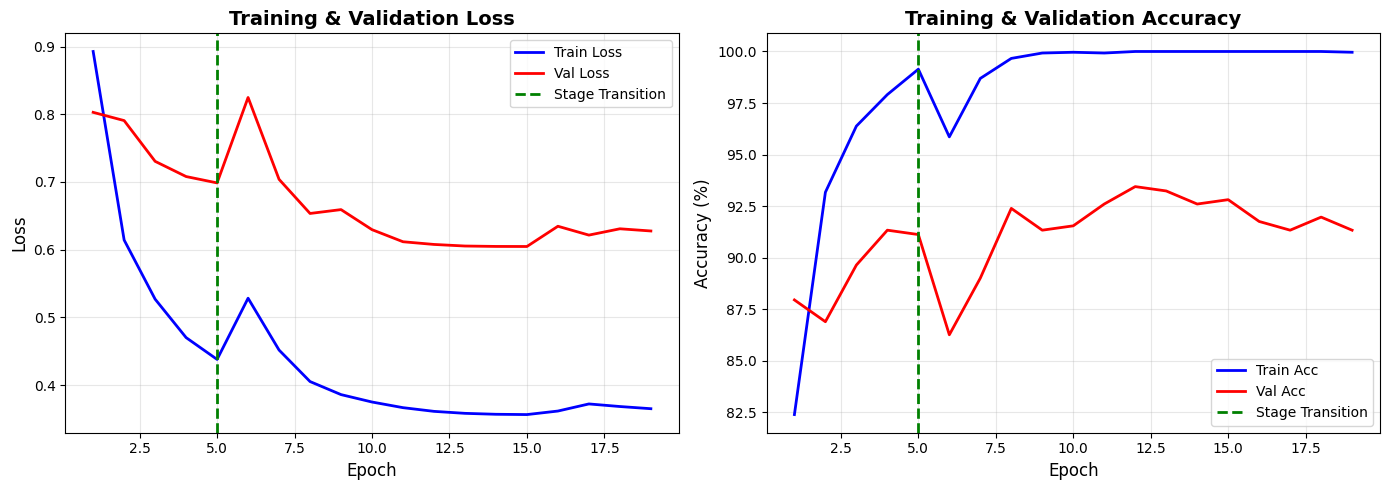


STEP 10: Verify Model Checkpoint
------------------------------------------------------------
✅ Model checkpoint found!
   Location: /kaggle/working/checkpoints/best_model.pth
   Best accuracy: 93.45%
   Training stage: full_finetuning
   Epoch: 6
   File size: 3483.93 MB

TRAINING COMPLETED SUCCESSFULLY
📁 Output files:
   • Model: /kaggle/working/checkpoints/best_model.pth
   • Class mapping: class_mapping.json
   • Training history: training_history.json
   • Training plot: training_history.png



In [26]:
# Run training
# Option 1: Use tuned hyperparameters (if available)
trainer, history = run_training(use_tuned_params=True)

# Option 2: Force using default CONFIG (uncomment below)
# trainer, history = run_training(use_tuned_params=False)

## Run Inference

**⚠️ IMPORTANT**: You must run training first before inference!

**Prerequisites:**
1. ✅ Training completed (cell above must be executed first)
2. ✅ Model file exists: `/kaggle/working/checkpoints/best_model.pth`
3. ✅ Class mapping exists: `class_mapping.json`

**If you see "Model not found" error:**
- Go back to the "Run Training" section above
- Execute the training cell: `trainer, history = run_training(use_tuned_params=True)`
- Wait for training to complete (this takes several hours)
- Then come back and run this cell

**Alternative:** Use the "Run Both Training and Inference Together" section below to run everything in one go.

In [27]:
# Check if model exists before running inference
model_path = Path(CONFIG['checkpoint_dir']) / 'best_model.pth'

if not model_path.exists():
    print("="*60)
    print("❌ ERROR: Model not found!")
    print("="*60)
    print(f"Looking for model at: {model_path}")
    print("\nYou need to train the model first!")
    print("\nSteps to fix:")
    print("1. Scroll up to '## Run Training' section")
    print("2. Execute the training cell")
    print("3. Wait for training to complete")
    print("4. Come back and run this cell again")
    print("="*60)
    submission_df = None
else:
    print("✅ Model found! Starting inference...")
    # Run inference and generate submission
    submission_df = run_inference()

✅ Model found! Starting inference...
Starting Inference Pipeline
Random seed set to: 42
Model loaded (accuracy: 93.45%)
Found 2057 images in root directory
Found 2057 images


Predicting: 100%|██████████| 2057/2057 [22:58<00:00,  1.49it/s]

Submission saved to /kaggle/working/submission.csv

Statistics:
Total predictions: 2057
Mean confidence: 81.81%
Min confidence: 16.30%
Max confidence: 97.90%

Preview:
   ID        label
0   1  Sate Padang
1   2    Gado Gado
2   3  Ayam Goreng
3   4      Rendang
4   5  Ayam Goreng
5   6         Soto
6   7   Ayam Bakar
7   8        Gudeg
8   9        Bakso
9  10       Pempek

Inference completed successfully


## Alternative: Run Both Training and Inference Together

**✨ RECOMMENDED FOR FIRST-TIME USERS**

This cell will automatically:
1. Run training (with optional hyperparameter tuning)
2. Generate predictions on test set
3. Create submission.csv

**Simply uncomment the code below and run this cell once.**
This is the easiest way to get results without running training and inference separately.

**Estimated time:** 5-8 hours on Kaggle GPU (P100/T4)

In [28]:
# # Complete Pipeline - Train and Inference in one go
# def run_complete_pipeline():
#     print("="*60)
#     print("COMPLETE PIPELINE: TRAINING + INFERENCE")
#     print("="*60)
#     print()
    
#     # Step 1: Training
#     print("STEP 1: Training Model")
#     print("-"*60)
#     trainer, history = run_training(use_tuned_params=True)
    
#     print()
#     print("="*60)
    
#     # Step 2: Inference
#     print("STEP 2: Running Inference")
#     print("-"*60)
#     submission_df = run_inference()
    
#     print()
#     print("="*60)
#     print("PIPELINE COMPLETED SUCCESSFULLY!")
#     print("="*60)
#     print(f"Model saved to: {CONFIG['checkpoint_dir']}/best_model.pth")
#     print(f"Submission saved to: {CONFIG['output_csv']}")
#     print()
    
#     return trainer, history, submission_df

# # Uncomment below to run complete pipeline
# # trainer, history, submission_df = run_complete_pipeline()

## Troubleshooting for Kaggle

In [29]:
# # Troubleshooting Tools for Kaggle

# # 1. Check current directory and available folders
# def check_environment():
#     print("Current Directory:", os.getcwd())
#     print("\nAvailable Folders:")
#     for item in Path('.').iterdir():
#         if item.is_dir() and not item.name.startswith('.'):
#             print(f"  - {item.name}/")
#     print()

# # 2. Check GPU availability
# def check_gpu():
#     print("GPU Check:")
#     print(f"  CUDA Available: {torch.cuda.is_available()}")
#     if torch.cuda.is_available():
#         print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
#         print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
#     print()

# # 3. Check dataset structure
# def check_dataset():
#     dataset_path = Path(CONFIG['dataset_path'])
#     if not dataset_path.exists():
#         print(f"ERROR: Dataset not found at {dataset_path}")
#         return
    
#     print(f"Dataset Structure ({dataset_path}):")
#     for class_dir in sorted(dataset_path.iterdir()):
#         if class_dir.is_dir():
#             img_count = len([f for f in class_dir.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])
#             print(f"  {class_dir.name}: {img_count} images")
#     print()

# # 4. Check test directory structure
# def check_test_dir():
#     test_path = Path(CONFIG['test_dir'])
#     if not test_path.exists():
#         print(f"ERROR: Test directory not found at {test_path}")
#         return
    
#     print(f"Test Directory Structure ({test_path}):")
#     for item in sorted(test_path.iterdir()):
#         if item.is_dir():
#             img_count = len([f for f in item.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])
#             print(f"  {item.name}/: {img_count} images")
#         elif item.suffix == '.csv':
#             print(f"  {item.name} (CSV file)")
#     print()

# # Run all checks
# print("="*60)
# print("ENVIRONMENT DIAGNOSTIC")
# print("="*60)
# check_environment()
# check_gpu()
# check_dataset()
# check_test_dir()

## Download Results (For Colab Only)

In [30]:
# # Download results to your local machine (Colab only)
# if IN_COLAB:
#     from google.colab import files
    
#     print("Downloading results...")
    
#     # Download submission file
#     if Path(CONFIG['output_csv']).exists():
#         files.download(CONFIG['output_csv'])
#         print(f"Downloaded: {CONFIG['output_csv']}")
    
#     # Download model
#     model_path = Path(CONFIG['checkpoint_dir']) / 'best_model.pth'
#     if model_path.exists():
#         files.download(str(model_path))
#         print(f"Downloaded: {model_path}")
    
#     # Download training history plot
#     if Path('training_history.png').exists():
#         files.download('training_history.png')
#         print("Downloaded: training_history.png")
    
#     # Download training history JSON
#     if Path('training_history.json').exists():
#         files.download('training_history.json')
#         print("Downloaded: training_history.json")
    
#     print("\nAll files downloaded!")
# else:
#     print("This cell is only for Google Colab. Files are already in your local directory.")

## Evaluation - Compare Submission with Ground Truth

In [31]:
def evaluate_submission(submission_csv, ground_truth_csv):
    """
    Compare submission with ground truth and calculate accuracy
    
    Args:
        submission_csv: Path to submission file
        ground_truth_csv: Path to ground truth file (jawaban/test.csv)
    
    Returns:
        Dictionary with evaluation metrics
    """
    print("="*60)
    print("Evaluating Submission Against Ground Truth")
    print("="*60)
    
    # Check if files exist
    if not Path(submission_csv).exists():
        print(f"Error: Submission file not found at {submission_csv}")
        return None
    
    if not Path(ground_truth_csv).exists():
        print(f"Error: Ground truth file not found at {ground_truth_csv}")
        return None
    
    # Load both files
    submission_df = pd.read_csv(submission_csv)
    ground_truth_df = pd.read_csv(ground_truth_csv)
    
    print(f"Submission entries: {len(submission_df)}")
    print(f"Ground truth entries: {len(ground_truth_df)}")
    
    # Merge on ID
    merged_df = pd.merge(
        submission_df, 
        ground_truth_df, 
        on='ID', 
        how='inner',
        suffixes=('_pred', '_true')
    )
    
    if len(merged_df) == 0:
        print("Error: No matching IDs found between submission and ground truth")
        return None
    
    print(f"Matching entries: {len(merged_df)}")
    
    # Calculate accuracy
    correct = (merged_df['label_pred'] == merged_df['label_true']).sum()
    total = len(merged_df)
    accuracy = (correct / total) * 100
    
    print(f"\n{'='*60}")
    print(f"EVALUATION RESULTS")
    print(f"{'='*60}")
    print(f"Total samples evaluated: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Wrong predictions: {total - correct}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"{'='*60}")
    
    # Show per-class accuracy
    print(f"\nPer-Class Performance:")
    print(f"{'-'*60}")
    
    class_stats = []
    for class_name in sorted(merged_df['label_true'].unique()):
        class_mask = merged_df['label_true'] == class_name
        class_df = merged_df[class_mask]
        class_correct = (class_df['label_pred'] == class_df['label_true']).sum()
        class_total = len(class_df)
        class_acc = (class_correct / class_total) * 100 if class_total > 0 else 0
        
        class_stats.append({
            'class': class_name,
            'correct': class_correct,
            'total': class_total,
            'accuracy': class_acc
        })
        
        print(f"{class_name:20s}: {class_correct:3d}/{class_total:3d} = {class_acc:6.2f}%")
    
    print(f"{'-'*60}")
    
    # Show confusion examples (wrong predictions)
    wrong_df = merged_df[merged_df['label_pred'] != merged_df['label_true']]
    
    if len(wrong_df) > 0:
        print(f"\nSample Wrong Predictions (showing up to 10):")
        print(f"{'-'*60}")
        for idx, row in wrong_df.head(10).iterrows():
            print(f"ID: {row['ID']} | True: {row['label_true']:20s} | Predicted: {row['label_pred']:20s}")
        
        if len(wrong_df) > 10:
            print(f"... and {len(wrong_df) - 10} more wrong predictions")
        print(f"{'-'*60}")
    
    # Create confusion matrix visualization
    from sklearn.metrics import confusion_matrix, classification_report
    
    y_true = merged_df['label_true']
    y_pred = merged_df['label_pred']
    
    print(f"\nClassification Report:")
    print(f"{'-'*60}")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    # Return results
    results = {
        'total': total,
        'correct': correct,
        'wrong': total - correct,
        'accuracy': accuracy,
        'class_stats': class_stats,
        'merged_df': merged_df,
        'wrong_predictions': wrong_df
    }
    
    return results

print("Evaluation function defined")

Evaluation function defined


In [32]:
# Run evaluation
eval_results = evaluate_submission(
    submission_csv=CONFIG['output_csv'],
    ground_truth_csv=CONFIG['ground_truth_csv']
)

if eval_results:
    print(f"\nEvaluation completed successfully!")
    print(f"Final Accuracy: {eval_results['accuracy']:.2f}%")

Evaluating Submission Against Ground Truth
Submission entries: 2057
Ground truth entries: 2057
Matching entries: 2057

EVALUATION RESULTS
Total samples evaluated: 2057
Correct predictions: 1936
Wrong predictions: 121
Accuracy: 94.12%

Per-Class Performance:
------------------------------------------------------------
Ayam Bakar          : 140/157 =  89.17%
Ayam Betutu         :  74/ 80 =  92.50%
Ayam Goreng         : 203/226 =  89.82%
Ayam Pop            :  81/ 85 =  95.29%
Bakso               : 157/160 =  98.12%
Coto Makassar       : 110/115 =  95.65%
Gado Gado           :  97/103 =  94.17%
Gudeg               :  41/ 55 =  74.55%
Nasi Goreng         : 237/242 =  97.93%
Pempek              : 135/139 =  97.12%
Rawon               :  80/ 85 =  94.12%
Rendang             :  76/ 83 =  91.57%
Sate Madura         : 190/199 =  95.48%
Sate Padang         : 136/144 =  94.44%
Soto                : 179/184 =  97.28%
------------------------------------------------------------

Sample Wrong Predic

Confusion matrix saved to: confusion_matrix.png


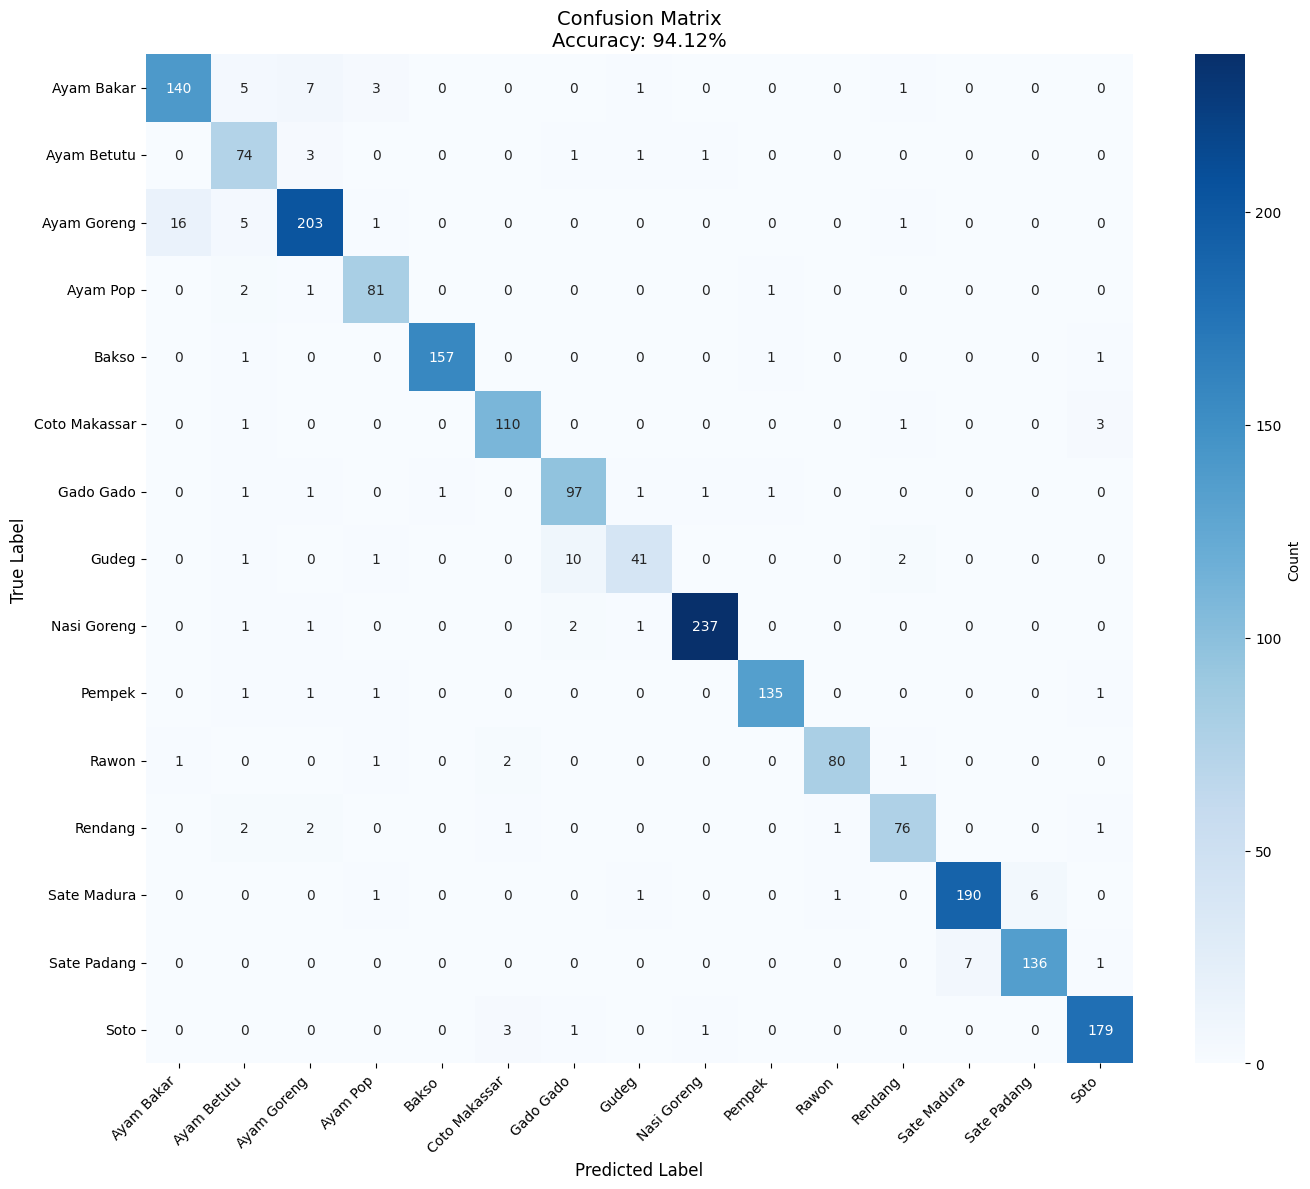

In [33]:
# Visualize Confusion Matrix (optional)
def plot_confusion_matrix(eval_results):
    """Plot confusion matrix from evaluation results"""
    if eval_results is None:
        print("No evaluation results to plot")
        return
    
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    merged_df = eval_results['merged_df']
    y_true = merged_df['label_true']
    y_pred = merged_df['label_pred']
    
    # Get unique labels
    labels = sorted(list(set(y_true) | set(y_pred)))
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Plot
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix\nAccuracy: {eval_results["accuracy"]:.2f}%', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
    print("Confusion matrix saved to: confusion_matrix.png")
    plt.show()

# Uncomment to plot confusion matrix
if eval_results:
    plot_confusion_matrix(eval_results)